<a href="https://colab.research.google.com/github/ImagingDataCommons/ai_medima_misc/blob/main/usage_notebooks/scientific_data_paper_usage_notes_nsclc_radiomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides instructions on how to create, interpret and visualize the data associated with the Scientific Data Paper [insert]. 

Before beginning, please set up a project using these instructions [insert]. 

We demonstrate how to: 
- Convert the DICOM Segmentation objects using multiple packages 
- Analyze the DICOM Structured Reports that hold the 3D shape radiomics features
- Analyze the DICOM Structured Reports that hold the body part landmarks and regions 

-- 

To do: 
- make the install packages/parameterization/environment setup easier!! 
- include instructions/link to creating a project 


Deepa Krishnaswamy
Brigham and Women's Hospital 
Dec 2022 

Meeting 3-6-23
- git issue highdicom converting to nii, need orientation -> form as itk image instead, done
- For the landmarks -- go from landmark to list of series that have the landmark -> almost done 
- For the regions -- go from region to list of series that have the region -> TO DO. 
- Maybe split notebook later -> TO DO. 
- Use pydicom_seg as well -> done
- For viz use Dennis' method as well as ITK widgets -> done 
- Also provide examples of reading the SRs! -> almost done
- radiomics - Go from feature to patient?? --> can't remember...
- How to extract from SRs and put this after the querying. --> done 
- Sort by the number of slices/landmarks to see coverage ? 


# Parameterization

In [152]:
project_name = 'idc-external-018'
dataset_table_id = 'dataset_nsclc' 
nnunet_comparison_table_id = 'usage_notebook_nnunet_comparison_table'

# Authorize 
from google.colab import auth
auth.authenticate_user()

# Install packages 

In [153]:
!pip install pyradiomics

!pip install pyplastimatch

!pip uninstall highdicom
!git clone https://github.com/herrmannlab/highdicom.git
#!cd highdicom && python setup.py install
!cd highdicom && pip install .

!pip install pydicom
!pip install pydicom-seg

!pip install --upgrade --pre -q "itk==5.3.0"
!pip install 'itkwidgets>=1.0a23'
!pip install imjoy-elfinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: highdicom 0.20.0
Uninstalling highdicom-0.20.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/highdicom-0.20.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/highdicom/*
Proceed (Y/n)? Y
  Successfully uninstalled highdicom-0.20.0
fatal: destination path 'highdicom' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/highdicom
  Preparing metadata (setup.py) ... done
  Created wheel for highdicom: filename=highdicom-0.20.0-py3-none-any.whl size=801315 sha256=14786c1e1ff1c236313e6266a8e4059c6daf5d91762147cb045bbef946e3c881
  Stored in directory: /tmp/pip-ephem-wheel-cache-xieleak1/wheels/f2/ff/ce/17393fe4b05937f7caccbf2e0f5f252c643a

In [154]:
%%capture
!apt install subversion

!svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/src
# !svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/data

In [155]:
!gcloud config set project $project_name

Updated property [core/project].


In [156]:
import os 
import sys 
import time 
import json 
import subprocess 
import glob
import shutil  

import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib 
import SimpleITK as sitk
import pandas as pd 
import seaborn as sb 
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

import pydicom
import pydicom_seg
from collections import OrderedDict

import itk 
from itkwidgets import view
from scipy import ndimage

import seaborn as sns

import src.utils.gcs as gcs
import src.utils.preprocessing as preprocessing
import src.utils.processing as processing
import src.utils.postprocessing as postprocessing



Let's install and import the packages needed to create Structured Reports (SR). -- I will simplify this later!

In [157]:
# Packages for the structured report 

import highdicom

from pathlib import Path

import highdicom as hd

from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion,
    SourceImageForMeasurement,
    SourceImageForMeasurementGroup
)
from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    MeasurementsAndQualitativeEvaluations,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation,
    ImageLibrary,
    ImageLibraryEntryDescriptors,
    ValueTypeValues # I added 
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)


We will next install and import a number of packages needed for organizing and converting DICOM files:

1.    `dicomsort`, a package for sorting DICOM files into a directory tree using specific DICOM fields. 
2.   `plastimatch`, a package used to convert RTSTRUCT DICOM files to nrrd. 
3.   `dcmqi`, a package which converts SEG DICOM files to nrrd.
4.  `dcm2niix`, a package for converting DICOM files to nii 


In [158]:
# %%capture
start_time=time.time()

# FIXME: see if we can convert this to a package as well
# dicomsort 
if os.path.isdir('/content/src/dicomsort'):
  try:
    shutil.rmtree('/content/src/dicomsort')
  except OSError as err:
    print("Error: %s : %s" % ("dicomsort", err.strerror)) 
# !git clone https://github.com/pieper/dicomsort.git 
!git clone https://github.com/pieper/dicomsort.git src/dicomsort

# plastimatch and pyplastimatch
# FIXME: already installed in one of the first cells (also takes care of some
# of the other dependencies, e.g., SITK) 
!sudo apt install plastimatch 
import pyplastimatch as pypla

# FIXME: see if we can convert this to a package as well
# dcmqi 
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

# dcm2niix 
# !sudo apt-get install dcm2niix 
# !curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip "/content/dcm2niix_lnx.zip"
!wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
!unzip dcm2niix_lnx.zip
!cp /content/dcm2niix /usr/local/bin 

end_time = time.time()
print ('time to install: ' + str(end_time-start_time))

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 169 (delta 23), reused 34 (delta 17), pack-reused 126
Receiving objects: 100% (169/169), 87.85 KiB | 502.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
plastimatch is already the newest version (1.8.0+dfsg.1-2build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
--2023-03-21 00:02:24--  https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/50675718/79d3ad95-9f0c-42a4-a1c5-bf5a63461894?X-Amz-Algorithm=AWS4-HMAC

# nnU-Net prediction analysis

## Download

### Download DICOM Segmentation objects 

Get the gcs url to download the SEG files 

In [ ]:
client = bigquery.Client(project=project_name)
# table_id = ".".join(['idc-dev-etl', 'idc_v13_pub', 'dicom_all']) # later will change to use idc_current. 
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    SeriesDescription,
    gcs_url
  FROM 
    {table_id}
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID, 
    StudyInstanceUID, 
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig()
seg_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


Choose single patient and download the files 

In [ ]:
PatientID = sorted(list(set(seg_df['PatientID'].values)))[1] 
print(PatientID)

LUNG1-002


In [ ]:
seg_df_patient = seg_df[seg_df['PatientID']==PatientID] 
seg_df_patient

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,SeriesDescription,gcs_url
4,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,1.2.276.0.7230010.3.1.4.2323910823.11504.15972...,Segmentation,gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...
5,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.112041.16656...,1.2.276.0.7230010.3.1.4.481034752.112041.16656...,3d_lowres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/99ce9653-4f74-4954-aa...
6,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.398262.16657...,1.2.276.0.7230010.3.1.4.481034752.398262.16657...,2d-tta_nnU-Net_Segmentation,gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9e...
7,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.481034752.68078.166429...,1.2.276.0.7230010.3.1.4.481034752.68078.166429...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/a8adc5d1-d4af-4653-96...


Download the SEG files 

In [ ]:
# Download all the DICOM Segmentation files 

# Create the text file to hold gsc_url 
gcsurl_temp = seg_df_patient["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
seg_directory = "/content/seg"
if not os.path.isdir(seg_directory):
  os.mkdir(seg_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $seg_directory

Copying gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bceaac5da9.dcm...
Copying gs://public-datasets-idc/99ce9653-4f74-4954-aa00-e94470abeee7.dcm...
Copying gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9ee9-e98d47b212d5.dcm...
Copying gs://public-datasets-idc/a8adc5d1-d4af-4653-966a-f0132333fd7e.dcm...
\ [4/4 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 4 objects/41.8 MiB.                                     


Use dicomsort to sort the DICOM files 

In [ ]:
# Sort files 
seg_directory_sorted = "/content/seg_sorted"
if not os.path.join(seg_directory_sorted):
  os.mkdir(seg_directory_sorted)

!python src/dicomsort/dicomsort.py -u $seg_directory $seg_directory_sorted/%PatientID/%Modality/%SeriesDescription.dcm



100% 4/4 [00:00<00:00,  4.13it/s]
Files sorted


In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

### Download the associated CT files 

In [ ]:
# Get the referenced seriesInstanceUID from the input_dicom 

dcm = pydicom.dcmread(input_dicom)
# series_id = dcm['0020', '000e'].value # later figure out what field to use. 
# series_id = dcm['0008', '1115']['0020', '000e'].value
series_id = dcm['0008', '1115'][0]['SeriesInstanceUID'].value # # later figure out what field to use. 


In [ ]:
client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url 
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

start_time = time.time()
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
result = client.query(query_view, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time)) 

elapsed time: 2.229651927947998


In [ ]:
# Download the gcs_urls 

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path

Copying gs://idc-open-cr/8d11ef77-909c-4de3-b550-cb3bd7f00d8a.dcm...
Copying gs://idc-open-cr/b670ab0d-71a0-4a30-af78-c0676666d81d.dcm...
Copying gs://idc-open-cr/07610515-ec98-4852-bdd8-0dd5a91f5478.dcm...
Copying gs://idc-open-cr/93361b61-85b9-4fc0-b015-d02245f2459c.dcm...
Copying gs://idc-open-cr/52ea13a8-f89b-4da0-8435-0293d117069a.dcm...
Copying gs://idc-open-cr/b85dc3e1-8c86-473d-a62d-0bb0f4b10a89.dcm...
Copying gs://idc-open-cr/ebed7073-8a61-46f8-adf0-929a39e1e8b8.dcm...
Copying gs://idc-open-cr/eafbfe99-84f0-44e5-a31d-21856912dc4d.dcm...
Copying gs://idc-open-cr/66065989-9029-40c3-9f3f-66794ecaca3b.dcm...
Copying gs://idc-open-cr/5f1ab5c8-0c48-45bd-9166-90449e14616b.dcm...
Copying gs://idc-open-cr/eb161df8-b9f1-4b30-89f1-cfe557671c48.dcm...
Copying gs://idc-open-cr/805b08bb-1935-4007-94a7-9ac04b14993a.dcm...
Copying gs://idc-open-cr/8ddfd645-fa50-4843-bce7-a629988a0c38.dcm...
Copying gs://idc-open-cr/29946a45-da88-447c-9738-56c75a3824e1.dcm...
Copying gs://idc-open-cr/867e960a-

## Conversion of DICOM files

### Convert the raw CT files to nii 

In [ ]:
# Convert to nifti 
ct_nifti_directory = "/content/ct_nii" 
if not os.path.isdir(ct_nifti_directory): 
  os.mkdir(ct_nifti_directory)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory, download_path)
print(cmd)
ret = os.system(cmd)
print(ret)

dcm2niix -z y -m y -o /content/ct_nii  /content/raw 
0


In [ ]:
# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory,f) for f in os.listdir(ct_nifti_directory) if f.endswith('.nii.gz')][0] 
nii_file = "/content/ct.nii.gz"
os.rename(nii_file_orig, nii_file)


### Use dcmqi to convert the DICOM Segmentation object to a nifti file 

Insert text of the output of dcmqi. 

In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

In [ ]:
output_directory_seg_converted_dcmqi = "/content/seg_converted_dcmqi"
if not os.path.isdir(output_directory_seg_converted_dcmqi):
  os.mkdir(output_directory_seg_converted_dcmqi)

print(input_dicom)
print(output_directory_seg_converted_dcmqi)

# !segimage2itkimage --outputType "nrrd" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 
!segimage2itkimage --outputType "nii" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 


/content/seg_sorted/LUNG1-002/SEG/2d-tta_nnU-Net_Segmentation.dcm
/content/seg_converted_dcmqi
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 -1 0
Z direction: 0 0 -1
Total frames: 205
Total frames with unique IPP: 85
Total overlapping frames: 77
Origin: [-250.112, 249.135, 154.6]


Resample the segmentation back to the original size

In [ ]:
nii_file

'/content/ct.nii.gz'

In [ ]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_dcmqi,f) for f in os.listdir(output_directory_seg_converted_dcmqi) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_dcmqi_resampled = "/content/seg_converted_dcmqi_resampled"
if not os.path.isdir(output_directory_seg_converted_dcmqi_resampled):
  os.mkdir(output_directory_seg_converted_dcmqi_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_dcmqi, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_dcmqi_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

num_seg_files: 4
Trying to write image to /content/seg_converted_dcmqi_resampled/1.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/2.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/3.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/4.nii.gz


In [ ]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_dcmqi_resampled,f) for f in os.listdir(output_directory_seg_converted_dcmqi_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
    
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_dcmqi_resampled.nii.gz')


[0. 1. 2. 3. 4.]


### Use pydicom_seg to convert the DICOM Segmentation object to a nifti file

In [ ]:
!pip install pydicom-seg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydicom
import pydicom_seg
import SimpleITK as sitk

output_directory_seg_converted_pydicom = "/content/seg_converted_pydicom"
if not os.path.isdir(output_directory_seg_converted_pydicom):
  os.mkdir(output_directory_seg_converted_pydicom)

dcm = pydicom.dcmread(input_dicom)

reader = pydicom_seg.SegmentReader()
result = reader.read(dcm)

for segment_number in result.available_segments:
    image_data = result.segment_data(segment_number)  # directly available
    image = result.segment_image(segment_number)  # lazy construction
    print(image.GetSize())
    # sitk.WriteImage(image, f'/content/pydicom_seg/segmentation-{segment_number}.nii.gz', True) 
    sitk.WriteImage(image, f'/content/seg_converted_pydicom/{segment_number}.nii.gz', True) # resample back to CT in next step 


(512, 512, 85)
(512, 512, 85)
(512, 512, 85)
(512, 512, 85)


In [ ]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_pydicom,f) for f in os.listdir(output_directory_seg_converted_pydicom) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_pydicom_resampled = "/content/seg_converted_pydicom_seg_resampled"
if not os.path.isdir(output_directory_seg_converted_pydicom_resampled):
  os.mkdir(output_directory_seg_converted_pydicom_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_pydicom, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_pydicom_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn



num_seg_files: 4
Trying to write image to /content/seg_converted_pydicom_seg_resampled/1.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/2.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/3.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/4.nii.gz


In [ ]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_pydicom_resampled,f) for f in os.listdir(output_directory_seg_converted_pydicom_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_pydicom_resampled.nii.gz')

[0. 1. 2. 3. 4.]


###  Use highdicom + code from dcmqi to convert the DICOM Segmentation object to a nifti file 

Using seg = hd.seg.segread and seg.get_pixels_by_source_instance, we can get the segmentation labels as a numpy array. Unfortunately, we are not returned information about the orientation and therefore do not have a way of mapping this back to the same space as the CT. 

Therefore, we get the position and orientation information ourselves and reconstruct a 3D volume. As reference we use https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483

In [ ]:
# Use highdicom to read the DICOM Segmentation file 
seg = hd.seg.segread(input_dicom) 

# Extract orientation information we need for reconstruction
Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))

Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [ ]:
# ------------------ # 
# Using the PerFrameFunctionalGroupsSequence, we extract the segment_number (in our case we have 4 segments), 
# and the associated ImagePositionPatient for each of the slices 

# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))

segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_number = np.asarray(segment_number)
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)

# Create a dict to store the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))

# ------------------ # 
# We then need to compute the volume Extent, by getting the number of unique ImagePositionPatient values 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# ------------------- # 
# We need to calculate the image origin which will be used for stacking the 
# slices for each of the segments in the right order 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

num_seg_slices: 205
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [ ]:
# This function is to map the ImagePositionPatient to an axial slice index value 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 

  return slice_index 

In [ ]:
# --------------------------# 
# Now we form the volume

# We get the pixel_array from seg - this concatenates all labels in the x axis 
pixel_array = seg.pixel_array 
print('pixel_array: ' + str(pixel_array.shape))

# We want to form a single volume for all labels 
volume = np.zeros((Rows, Columns, num_slices)) 
print('volume: ' + str(volume.shape))

# This is an index to make sure it is the same as the x value for pixel_array 
matching_rows_sum = 0 

# For each axial slice, and for each segment present in that slice, we add 
# the appropriate labels 
for n in range(0,num_slices):

  # Get a unique IPP 
  imagepositionpatient = unique_ImagePositionPatient[n,:]

  # Find the matching rows indices in segment_ImagePositionPatient 
  # The length of this is equal to the number of segments that are present in the same slice 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])

  # Get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]

  # Get the axial slice index for this unique IPP 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  
  # Use this index to make sure it is the same as the x value for pixel_array 
  matching_rows_sum += len(matching_segment_numbers)

  # For each segment present in the slice, add the appropriate slice from the pixel_array 
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

# Print some error checking 
print('Number of axial slices: ' + str(len(unique_ImagePositionPatient))) # Should be equal to the number of slices in our final volume 
print('Segment numbers: ' + str(np.unique(volume))) # Should be the segment numbers 
print('matching_rows_sum: ' + str(matching_rows_sum)) # Should be equal to the x axis of pixel_array

pixel_array: (205, 512, 512)
volume: (512, 512, 85)
Number of axial slices: 85
Segment numbers: [0. 1. 2. 3. 4.]
matching_rows_sum: 205


#### Convert to ITK image and save as nifti

In [ ]:
print('original volume: ' + str(volume.shape))
volume = np.rollaxis(volume, 2, 0)
print ('volume: ' + str(volume.shape))

itk_volume = sitk.GetImageFromArray(volume)
spacing = [np.float64(PixelSpacing_x), np.float64(PixelSpacing_y), np.float64(SpacingBetweenSlices)]
origin = [np.float64(ImageOrigin_max[0]), np.float64(ImageOrigin_max[1]), np.float64(ImageOrigin_max[2])]
direction = np.zeros((3,3)) 
direction[0,:] = [np.float64(ImageOrientationPatient_x[0]), 
                  np.float64(ImageOrientationPatient_x[1]), 
                  np.float64(ImageOrientationPatient_x[2])]
direction[1,:] = [np.float64(ImageOrientationPatient_y[0]), 
                  np.float64(ImageOrientationPatient_y[1]), 
                  np.float64(ImageOrientationPatient_y[2])]
direction[2,:] = [np.float64(sliceDirection[0]), 
                  np.float64(sliceDirection[1]), 
                  np.float64(sliceDirection[2])]
direction = np.hstack(direction)
print('spacing: ' + str(spacing)) 
print('origin: ' + str(origin))
print('direction: ' + str(direction)) 

itk_volume.SetSpacing(spacing) 
itk_volume.SetOrigin(origin)
itk_volume.SetDirection(direction) 

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

outputImageFileName = os.path.join(output_directory_seg_converted_highdicom, "highdicom_volume.nii.gz")
writer = sitk.ImageFileWriter()
writer.SetFileName(outputImageFileName)
writer.Execute(itk_volume)

original volume: (512, 512, 85)
volume: (85, 512, 512)
spacing: [0.9769999980926514, 0.9769999980926514, 3.0]
origin: [-250.11199951171875, 249.135009765625, 154.60000610351562]
direction: [ 1.  0.  0.  0. -1.  0.  0.  0. -1.]


In [ ]:
# ----------------- # 
# Now we can resample this nifti file back to the original CT space 

# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image # --interpolation nn

Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


#### (delete later) Convert to nifti image directly

In [ ]:
# --------------- # 
# Now that we have the volume, and the associated orientation information, we can form a nifti file 

# First set the appropriate srows 
srow_x = ImageOrientationPatient_x * PixelSpacing_x 
srow_y = ImageOrientationPatient_y * PixelSpacing_y 
srow_z = sliceDirection * SpacingBetweenSlices 
print(srow_x)
print(srow_y)
print(srow_z)

# Create the proper header for the nifti file 
volume = volume.astype(np.uint8)
print(type(volume))
print(volume.dtype)
nii = nib.Nifti1Image(volume, np.eye(4))
header = nii.header 
header['pixdim'] = [1, PixelSpacing_x, PixelSpacing_y, SpacingBetweenSlices, 1, 1, 1, 1,]   

# This works but why?? Have to multiple origin by sliceDirection or something?? 
header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], -ImageOrigin_max[1] ]
header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], -ImageOrigin_max[0] ]
header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2] ]

print(header)

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

nii = nib.Nifti1Image(volume, None, header)
nib.save(nii, os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz'))


[0.977 0.    0.   ]
[ 0.    -0.977  0.   ]
[ 0.  0. -3.]
<class 'numpy.ndarray'>
uint8
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  85 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.    0.977 0.977 3.    1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x    

In [ ]:
# ----------------- # 
# Now we can resample this nifti file back to the original CT space 

# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


In [ ]:
shutil.copy(seg_file_resampled, "/content/segmentation_highdicom_resampled.nii.gz")


'/content/segmentation_highdicom_resampled.nii.gz'

### OLD - DELETE later. Use highdicom + code from dcmqi to convert the DICOM Segmentation objects to a nifti file 

We should not have to pass in the source_sops from the CT files in order to recreate the segmentations. Instead, read the segmentations using the highdicom code, and then manually recreate the 3D numpy array with the proper spacing etc ourselves only by using data from the DICOM SEG file. 

Notes: 
https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483 

In [ ]:
seg = hd.seg.segread(input_dicom) 
source_uids = seg.get_source_image_uids() 
source_sops = [uids[2] for uids in source_uids]

pix = seg.get_pixels_by_source_instance(
          source_sops, 
          ignore_spatial_locations=True,
          # segment_numbers=[1,2,3,4], 
          assert_missing_frames_are_empty=True,
          combine_segments=True
)

print (pix.shape) # (85, 512, 512), original CT is (111, 512, 512)

(85, 512, 512)


In [ ]:
import numpy as np 

Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print ('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))


Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [ ]:
# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))
segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)
# print(segment_number) 
# print(segment_ImagePositionPatient)

segment_number = np.asarray(segment_number)


num_seg_slices: 205


In [ ]:
# This is the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
print('number_of_segments: ' + str(number_of_segments)) 
print('segment_number_of_frames: ' + str(segment_number_of_frames))
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))
segment_number_dict.keys()
segment_number_dict[1]

# print(len(seg.PerFrameFunctionalGroupsSequence))

## Compute the volumeExtent -- number of unique ImagePositionPatient? 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
print('unique_ImagePositionPatient: ' + str(len(unique_ImagePositionPatient)))
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

number_of_segments: [1 2 3 4]
segment_number_of_frames: [77 26 39 63]
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
unique_ImagePositionPatient: 85
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [ ]:
# def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind):

#   dist = imagepositionpatient - ImageOrigin 
#   slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )

#   # print('imagepositionpatient: ' + str(imagepositionpatient))
#   # print('ImageOrigin: ' + str(ImageOrigin))
#   # print('dist: ' + str(dist))
#   # print('dist[max_ind]: ' + str(dist[max_ind]))
#   # print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices))

#   return slice_index 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 


  # print('imagepositionpatient: ' + str(imagepositionpatient))
  # print('ImageOrigin: ' + str(ImageOrigin))
  # print('dist: ' + str(dist))
  # print('dist[max_ind]: ' + str(dist[max_ind]))
  # print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices))

  return slice_index 

In [ ]:
# Form the volume 

pixel_array = seg.pixel_array #(205,512,512) 

# volume = np.zeros((Rows, Columns, num_slices, len(number_of_segments)))
volume = np.zeros((Rows, Columns, num_slices))
print('volume: ' + str(volume.shape))

matching_rows_sum = 0 

for n in range(0,num_slices):
  imagepositionpatient = unique_ImagePositionPatient[n,:]
  # find the matching rows indices in segment_ImagePositionPatient 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])
  # get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]
  # get the corresponding 2D array for each from seg.pixel_array 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  # print('slice_num: ' + str(slice_num))
  matching_rows_sum += len(matching_segment_numbers)
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

print(len(unique_ImagePositionPatient))
print(np.unique(volume))
print('matching_rows_sum: ' + str(matching_rows_sum)) # should be 205, it is. 

volume: (512, 512, 85)
85
[0. 1. 2. 3. 4.]
matching_rows_sum: 205


In [ ]:
print(np.unique(pixel_array))
print(np.unique(pix))
print(np.unique(volume))

[0 1]
[0 1 2 3 4]
[0. 1. 2. 3. 4.]


In [ ]:
print(ImageOrientationPatient_x)
print(ImageOrientationPatient_y)
print(sliceDirection)
print(SpacingBetweenSlices)

# srow_x = ImageOrientationPatient_x * PixelSpacing_x 
# srow_y = ImageOrientationPatient_y * PixelSpacing_y 
# srow_x = ImageOrientationPatient_y * PixelSpacing_y 
# srow_y = ImageOrientationPatient_x * PixelSpacing_x 
srow_x = ImageOrientationPatient_x * PixelSpacing_x 
srow_y = ImageOrientationPatient_y * PixelSpacing_y 
srow_z = sliceDirection * SpacingBetweenSlices 
print(srow_x)
print(srow_y)
print(srow_z)

print(ImageOrigin_max)

[1. 0. 0.]
[ 0. -1.  0.]
[ 0.  0. -1.]
3.0
[0.977 0.    0.   ]
[ 0.    -0.977  0.   ]
[ 0.  0. -3.]
[-250.112    249.13501  154.6    ]


In [ ]:
# Create the proper header for the nifti file 
volume = volume.astype(np.uint8)
print(type(volume))
print(volume.dtype)
nii = nib.Nifti1Image(volume, np.eye(4))
header = nii.header 
header['pixdim'] = [1, PixelSpacing_x, PixelSpacing_y, SpacingBetweenSlices, 1, 1, 1, 1,]   

# header['srow_x'] = [  ImageOrientationPatient_x[0]*PixelSpacing_x,      0,      0,    ImageOrigin[0]]
# header['srow_y'] = [ 0,     ImageOrientationPatient_y[1]*PixelSpacing_y,  0, ImageOrigin[1]]
# header['srow_z'] = [ 0, 0, SpacingBetweenSlices, sliceDirection[2]*ImageOrigin[2]]

# header['srow_x'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_y'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_x'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[1]]
# header['srow_y'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[0]]

# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]

# This almost works, but off by 1 pixel in x and y direction
# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

# This works but why?? Have to multiple origin by sliceDirection or something?? 
header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], -ImageOrigin_max[1]]
header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], -ImageOrigin_max[0]]
header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

# header['srow_y'] = [ srow_x[0], srow_x[1], srow_x[2], ImageOrigin_max[0]]
# header['srow_x'] = [ srow_y[0], srow_y[1], srow_y[2], ImageOrigin_max[1]]
# header['srow_z'] = [ srow_z[0], srow_z[1], srow_z[2], ImageOrigin_max[2]]

print(header)

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

nii = nib.Nifti1Image(volume, None, header)
nib.save(nii, os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz'))

<class 'numpy.ndarray'>
uint8
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  85   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.    0.977 0.977 3.    1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow

In [ ]:
# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn


Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


In [ ]:
# Copy so consistent, change later 

shutil.copy(seg_file_resampled, "/content/segmentation_highdicom_resampled.nii.gz")
 

'/content/segmentation_highdicom_resampled.nii.gz'

## Visualization of DICOM files and nifti files

### Use ITKWidgets to visualize the CT DICOM files and the DICOM Segmentation object

In [ ]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 

pro_ct_dir = '/content/raw'
pro_ct_image = itk.imread(pro_ct_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
pro_seg_file = '/content/seg_sorted/LUNG1-002/SEG/3d_fullres-tta_nnU-Net_Segmentation.dcm' # for now.
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)

In [ ]:
viewerA = view(image=pro_ct_image, 
               label_image=pro_seg_image)


In [ ]:
viewerA.set_image_color_map("Grayscale")
# viewerA.set_image_color_range([0,400])
viewerA.set_view_mode("ZPlane")
# viewerA.set_z_slice(53)
viewerA.set_ui_collapsed(False)

### Use ITKWidgets to view the CT nifti file and segmentation nifti file 

In [ ]:
# We need to convert our CT nifti and segmentation nifti files to ITK objects 

# print(nii_file)
# nii_file = '/content/ct.nii.gz'
ct_nii = nib.load('/content/ct.nii.gz') 
ct_data = ct_nii.get_fdata() 
ct_header = ct_nii.header 

ct_itk = itk.GetImageFromArray(ct_data) 
# ct_itk.SetOrigin(ct_header['origin'])
# ct_itk.SetSpacing(np.float32(ct_header['pixdim'][1:4]))
# ct_itk.SetDirection()

# itk_seg_image = itk.GetImageFromArray(itk_seg_obj.data.astype(np.float32))
# itk_seg_image.SetOrigin(itk_seg_obj.origin)
# itk_seg_image.SetSpacing(itk_seg_obj.spacing)
# itk_seg_image.SetDirection(itk_seg_obj.direction)

seg_nii = nib.load("/content/segmentation_dcmqi_resampled.nii.gz")
seg_data = seg_nii.get_fdata() 
seg_itk = itk.GetImageFromArray(seg_data)



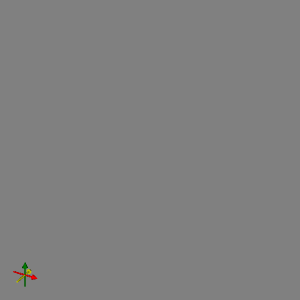
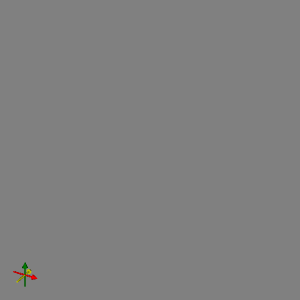

In [ ]:
viewerB = view(image=ct_itk, 
               label_image=seg_itk)
viewerB.set_image_color_map("Grayscale")
viewerB.set_ui_collapsed(False)
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(40)
viewerB.set_image_color_range([-1000,200]) # figure out good values later.


### Use custom code to overlay the CT numpy array and segmentation numpy array

In [ ]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils

from matplotlib.colors import ListedColormap

cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

In [ ]:
# Convert nii to nrrd for viz 
verbose = True 

log_file_path_nii = "/content/pypla.txt"
# convert_args_nii = {"input": "/content/raw", 
#                     "output-img": "/content/ct.nrrd"}
# pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

convert_args_nii = {"input": "/content/ct.nii.gz", 
                    "output-img": "/content/ct.nrrd"}
pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

if not os.path.isdir("/content/nrrd"): 
  os.mkdir("/content/nrrd")

for n in range(0,4): 
  input_img = os.path.join("/content/seg_converted_dcmqi_resampled", str(n+1)+".nii.gz")
  output_img = os.path.join("/content/nrrd", str(n+1)+".nrrd")
  convert_args_nii = {"input": input_img, 
                    "output-img": output_img}
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input /content/ct.nii.gz
  --output-img /content/ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/1.nii.gz
  --output-img /content/nrrd/1.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/2.nii.gz
  --output-img /content/nrrd/2.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/3.nii.gz
  --output-img /content/nrrd/3.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/4.nii.gz
  --output-img /content/nrrd/4.nrrd
... Done.


In [ ]:
# ct_data = nib.load("/content/ct.nii.gz").get_fdata() 
# print('ct_data: ' + str(ct_data.shape))

# pred_heart = nib.load("/content/seg_converted_dcmqi_resampled/2.nii.gz").get_fdata() 
# pred_aorta = nib.load("/content/seg_converted_dcmqi_resampled/4.nii.gz").get_fdata()
# pred_trachea = nib.load("/content/seg_converted_dcmqi_resampled/3.nii.gz").get_fdata()
# pred_esophagus = nib.load("/content/seg_converted_dcmqi_resampled/1.nii.gz").get_fdata()

# ct_data = np.rollaxis(ct_data, 2, 0)
# print('ct_data: ' + str(ct_data.shape))
# pred_heart = np.rollaxis(pred_heart, 2, 0); # pred_heart = np.swapaxes(pred_heart, 1, 2)
# pred_aorta = np.rollaxis(pred_aorta, 2, 0); # pred_aorta = np.swapaxes(pred_aorta, 1, 2)
# pred_trachea = np.rollaxis(pred_trachea, 2, 0); # pred_trachea = np.swapaxes(pred_trachea, 1, 2)
# pred_esophagus = np.rollaxis(pred_esophagus, 2, 0); # pred_esophagus = np.swapaxes(pred_esophagus, 1, 2)
# ct_data = np.swapaxes(ct_data, 1, 2)

In [ ]:
# _ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_data, 
#                                    segmask_dict = {"Heart" : pred_heart,
#                                                              "Aorta" : pred_aorta,
#                                                              "Trachea" : pred_trachea,
#                                                              "Esophagus" : pred_esophagus}, 
#                                    segmask_cmap_dict = {"Heart" : my_greens,
#                                                                "Aorta" : my_spring,
#                                                                "Esophagus" : my_reds,
#                                                                "Trachea" : my_blues}, 
#                                    dpi = 100)
ct_nrrd = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/ct.nrrd"), [False, True, False]))
pred_nrrd_heart = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/2.nrrd"), [False, True, False]))
pred_nrrd_aorta = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/4.nrrd"), [False, True, False]))
pred_nrrd_trachea = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/3.nrrd"), [False, True, False]))
pred_nrrd_esophagus = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/1.nrrd"), [False, True, False]))

_ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_nrrd, 
                                   segmask_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus}, 
                                   segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues}, 
                                   dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## (paper figure #3) NSCLC Radiomics comparison of expert segmentations and AI-derived segmentations

We first query to get a list of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection. We query for the ones that have a SegmentedPropertyType Code Meaning of Esophagus, Heart, Trachea or Aorta. The seg_SeriesInstanceUIDs will later be used to get a list of the corresponding AI-derived segmentations. 

In [175]:
client = bigquery.Client(project=project_name)

query = """

# First get a list of the SOPInstanceUIDs of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection
WITH seg_sops AS (
  SELECT 
    PatientID, 
    SeriesInstanceUID, 
    SOPInstanceUID,
    SeriesDescription,
    gcs_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics" AND 
    SeriesDescription = "Segmentation"
  ORDER BY 
    PatientID 
)

# Now join the above to get only the segmented_SeriesInstanceUIDs that have the regions we want
# We will use these to get the AI-derived DICOM Segmentation objects 
SELECT 
  DISTINCT(seg.segmented_SeriesInstanceUID), 
  seg.PatientID, 
  seg_sops.SOPInstanceUID,
  seg_sops.SeriesDescription,
  seg_sops.gcs_url

FROM 
  `bigquery-public-data.idc_current.segmentations` as seg 
JOIN 
  seg_sops 
ON 
  seg.SOPInstanceUID = seg_sops.SOPInstanceUID
WHERE
  seg.SegmentedPropertyType.CodeMeaning = "Esophagus" OR 
  seg.SegmentedPropertyType.CodeMeaning = "Heart" OR
  seg.SegmentedPropertyType.CodeMeaning = "Trachea" OR
  seg.SegmentedPropertyType.CodeMeaning = "Aorta"
ORDER BY 
  seg.PatientID; 

"""

job_config = bigquery.QueryJobConfig()
seg_expert_df = client.query(query, job_config=job_config).to_dataframe()


In [176]:
seg_expert_df

,segmented_SeriesInstanceUID,PatientID,SOPInstanceUID,SeriesDescription,gcs_url
0,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,LUNG1-002,1.2.276.0.7230010.3.1.4.2323910823.11504.15972...,Segmentation,gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...
1,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,LUNG1-003,1.2.276.0.7230010.3.1.4.2323910823.23864.15972...,Segmentation,gs://idc-open-cr/8b8ec28d-1e6f-41a3-85f6-d1dac...
2,1.3.6.1.4.1.32722.99.99.2809816144625926346520...,LUNG1-004,1.2.276.0.7230010.3.1.4.2323910823.4780.159726...,Segmentation,gs://idc-open-cr/a3619297-0f76-4fc2-8fc5-b5c59...
3,1.3.6.1.4.1.32722.99.99.3490584753983772067630...,LUNG1-005,1.2.276.0.7230010.3.1.4.2323910823.11644.15972...,Segmentation,gs://idc-open-cr/7481751e-53e9-437e-b70b-572a7...
4,1.3.6.1.4.1.32722.99.99.3022971486912680215644...,LUNG1-006,1.2.276.0.7230010.3.1.4.2323910823.21456.15972...,Segmentation,gs://idc-open-cr/2946c197-1cfb-4f68-951c-9dde3...
...,...,...,...,...,...
352,1.3.6.1.4.1.32722.99.99.1452469930699451440457...,LUNG1-418,1.2.276.0.7230010.3.1.4.2323910823.9396.159725...,Segmentation,gs://idc-open-cr/1847ef93-fae7-4282-9057-5be93...
353,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,LUNG1-419,1.2.276.0.7230010.3.1.4.2323910823.25160.15972...,Segmentation,gs://idc-open-cr/8300eea1-30fd-4710-a437-9331f...
354,1.3.6.1.4.1.32722.99.99.3116735173196404572362...,LUNG1-420,1.2.276.0.7230010.3.1.4.2323910823.1672.159725...,Segmentation,gs://idc-open-cr/66aa1bb6-32b6-47ca-aad3-3c29f...
355,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,LUNG1-421,1.2.276.0.7230010.3.1.4.2323910823.18724.15972...,Segmentation,gs://idc-open-cr/86dac2ac-a0f2-4738-a65b-4a711...


In [177]:
num_expert_seg = len(seg_expert_df)
print(num_expert_seg)

357


For each of the SeriesInstanceUIDs they reference, get a dataframe of the gcs_urls of the AI-derived segmentations 

In [178]:
seg_expert_series_ids = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

client = bigquery.Client(project=project_name)

query = """

# Now we need to get the gcs_urls etc for the AI-derived Segmentations, for the seriesInstanceUIDs from the expert 

# First we need to get the possible SOPInstanceUIDs for the seriesInstanceUIDs from the expert 
WITH seg_series AS (
  SELECT 
    PatientID, 
    segmented_SeriesInstanceUID, 
    SOPInstanceUID,
    SegmentedPropertyType.CodeMeaning as code_meaning
  FROM 
    `bigquery-public-data.idc_current.segmentations` 
  WHERE
    segmented_SeriesInstanceUID IN UNNEST(@series_ids) 
)  

# Now need to get the SeriesDescription and gcs_url for those DICOM Segmentation objects 
SELECT 
  DISTINCT(seg_series.segmented_SeriesInstanceUID),
  dicom_all.PatientID, 
  dicom_all.SOPInstanceUID,
  dicom_all.SeriesDescription,
  dicom_all.gcs_url
FROM 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all
JOIN 
  seg_series 
ON 
  seg_series.SOPInstanceUID = dicom_all.SOPInstanceUID 
WHERE
  dicom_all.Modality = "SEG" AND 
  dicom_all.SeriesDescription <> "Segmentation" # these are the expert segmentations, so we do not want to include them 
ORDER BY 
  dicom_all.PatientID
"""

job_config = bigquery.QueryJobConfig(    
    query_parameters=[
        bigquery.ArrayQueryParameter("series_ids", "STRING", seg_expert_series_ids)])
seg_ai_df = client.query(query, job_config=job_config).to_dataframe()

In [179]:
seg_ai_df

,segmented_SeriesInstanceUID,PatientID,SOPInstanceUID,SeriesDescription,gcs_url
0,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,LUNG1-002,1.2.276.0.7230010.3.1.4.481034752.398262.16657...,2d-tta_nnU-Net_Segmentation,gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9e...
1,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,LUNG1-002,1.2.276.0.7230010.3.1.4.481034752.112041.16656...,3d_lowres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/99ce9653-4f74-4954-aa...
2,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,LUNG1-002,1.2.276.0.7230010.3.1.4.481034752.68078.166429...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/a8adc5d1-d4af-4653-96...
3,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,LUNG1-003,1.2.276.0.7230010.3.1.4.481034752.78912.166430...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/b4cd5453-9747-4879-97...
4,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,LUNG1-003,1.2.276.0.7230010.3.1.4.481034752.407788.16657...,2d-tta_nnU-Net_Segmentation,gs://public-datasets-idc/87aa6d74-3fe4-487a-a2...
...,...,...,...,...,...
1042,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,LUNG1-421,1.2.276.0.7230010.3.1.4.481034752.186769.16656...,3d_lowres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/8bf532be-52be-4b37-b5...
1043,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,LUNG1-421,1.2.276.0.7230010.3.1.4.481034752.151621.16643...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/fd4200a5-9504-4664-b9...
1044,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,LUNG1-422,1.2.276.0.7230010.3.1.4.481034752.114804.16656...,3d_lowres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/988c0f1d-370b-4f47-95...
1045,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,LUNG1-422,1.2.276.0.7230010.3.1.4.481034752.71159.166429...,3d_fullres-tta_nnU-Net_Segmentation,gs://public-datasets-idc/b6544280-6be7-400e-bc...


In [180]:
len(set(seg_ai_df['segmented_SeriesInstanceUID'].values)) # 349, expert has 357 

349

The above seg_ai_df only has the patients that were processed. Therefore, we modify our seg_expert_df to include those patients. 

In [181]:
seg_ai_series = list(set(seg_ai_df['segmented_SeriesInstanceUID'].values))
seg_expert_df = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID'].isin(seg_ai_series)]
print(len(seg_expert_df))

349


For each series, download the expert SEG. For each nnunet model (will be 3 per series), download the AI derived SEG. Convert to nii and compute the Dice/HD metrics. We will store the results into a a dataframe. We will store this as a table in case we do not want to repeat the processing.  

In [182]:
# Set up the run parameters 

# Dice score and HD score table 
# If table doesn't exist, create the schema based on the above 

from google.cloud.exceptions import NotFound
client = bigquery.Client(project=project_name)

nnunet_comparison_table_id_fullname = '.'.join([project_name, dataset_table_id, nnunet_comparison_table_id])
print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname))

try:
  client.get_table(nnunet_comparison_table_id_fullname) 
  nnunet_comparison_table_exists = 1 
except NotFound: 
  nnunet_comparison_table_exists = 0 

if (nnunet_comparison_table_exists==0):

  schema = [
      bigquery.SchemaField("PatientID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("SeriesInstanceUID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("structure_name", "STRING", mode="REQUIRED"), # added
      bigquery.SchemaField("dice_score", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("hausdorff_distance", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("hausdorff_distance_95", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("model", "STRING", mode="REQUIRED"), 
  ] 

  table = bigquery.Table(nnunet_comparison_table_id_fullname, schema=schema)
  table = client.create_table(table)  # Make an API request.
  print(
      "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
  )

else: 
  print ("Table " + str(nnunet_comparison_table_id_fullname) + ' already exists.')


nnunet_comparison_table_id_fullname: idc-external-018.dataset_nsclc.usage_notebook_nnunet_comparison_table
Table idc-external-018.dataset_nsclc.usage_notebook_nnunet_comparison_table already exists.


In [183]:
def append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                          dataset_name, 
                                                          table_name, 
                                                          value_SeriesInstanceUID, 
                                                          value_structure_name, 
                                                          value_model_name, 
                                                          row_to_insert): 

  table_id_fullname = '.'.join([project_name, dataset_name, table_name])
  # print('table_id_fullname: ' + str(table_id_fullname))

  query = f"""
    SELECT 
      COUNT(SeriesInstanceUID) AS num_instances
    FROM 
      {table_id_fullname}
    WHERE 
      SeriesInstanceUID IN UNNEST (@pat_id_change) AND 
      structure_name IN UNNEST (@structure_name) AND 
      model IN UNNEST (@model_name);
  """
  job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("pat_id_change", "STRING", [value_SeriesInstanceUID]), 
                                                         bigquery.ArrayQueryParameter("structure_name", "STRING", [value_structure_name]), 
                                                         bigquery.ArrayQueryParameter("model_name", "STRING", [value_model_name]), 
                                                         ]) 
  client = bigquery.Client(project=project_name)
  result = client.query(query, job_config=job_config)
  df_result = result.to_dataframe()
  count = df_result['num_instances'][0]
  print(count)
  
  if (count>=1):
    print("Cannot insert row because seriesInstanceUID and structure exist in table")
  else:
    print("Inserting row into table")
    client = bigquery.Client(project=project_name)
    dataset = client.dataset(dataset_name)
    table_ref = dataset.table(table_name)
    client.insert_rows_json(table = table_ref,
                            json_rows = row_to_insert,
                            skip_invalid_rows = False,
                            ignore_unknown_values = False)

  return 


In [184]:
series_to_eval_id_list = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

ai_derived_comparison_df = pd.DataFrame() 
ai_derived_series_descriptions = list(set(seg_ai_df['SeriesDescription'].values))

print(ai_derived_series_descriptions)

['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


In [123]:
# series_to_eval_id_list = series_to_eval_id_list[0:1]
# series_to_eval_id_list

['1.3.6.1.4.1.32722.99.99.23507740616018260882925674231000042364']

In [ ]:
segmented_SeriesInstanceUIDs = [] 
structure_names = [] 
seriesDescriptions = [] 
dice_scores = [] 
hausdorff_distances = [] 
hausdorff_distances_95 = [] 

eval_dice = True 
eval_hausdorff = True

# --- for each series --- #
for idx, series_id in enumerate(series_to_eval_id_list):

  print("(%g/%g) Running evaluation for series %s"%(idx + 1, len(series_to_eval_id_list), series_id))

  # Get the df of the expert 
  seg_expert_df_series = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]

  patient_id = seg_expert_df_series["PatientID"].values[0] 
  print('PatientID: ' + str(patient_id))

  # Download expert 
  # Create the text file to hold gsc_url 
  gcsurl_temp = seg_expert_df_series["gcs_url"]
  gs_file_path = "gcs_paths.txt"
  gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
  # Download the series 
  seg_expert_directory = "/content/seg_expert"
  if not os.path.isdir(seg_expert_directory):
    os.mkdir(seg_expert_directory)
  # !cat manifest.txt | gsutil -m cp -I .
  !cat gcs_paths.txt | gsutil -m cp -I $seg_expert_directory

  # Rename this file 
  input_path = os.path.join(seg_expert_directory, os.listdir(seg_expert_directory)[0])
  output_path = os.path.join(seg_expert_directory, series_id + '.dcm')
  shutil.move(input_path,output_path)

  # Create the appropriate folders 
  manual_dicomseg_path = output_path
  manual_seg_folder_path = "/content/seg_expert_nrrd"
  if not os.path.isdir(manual_seg_folder_path): 
    os.mkdir(manual_seg_folder_path)

  # convert the DICOM SEG obbject storing the inference results into NRRD
  postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = manual_dicomseg_path,
                                  path_to_output_dir = manual_seg_folder_path)

  # Get the df of the ai-derived 
  seg_ai_df_series = seg_ai_df[seg_ai_df['segmented_SeriesInstanceUID']==series_id]

  # --- for each model ---# 
  for nnunet_model in ai_derived_series_descriptions: 

    print ('nnunet_model: ' + str(nnunet_model))

    # Get the gcs_url of the specific model 
    seg_ai_df_series_model = seg_ai_df_series[seg_ai_df_series['SeriesDescription']==nnunet_model]

    # Download ai derived 
    # Create the text file to hold gsc_url 
    gcsurl_temp = seg_ai_df_series_model["gcs_url"]
    gs_file_path = "gcs_paths.txt"
    gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
    # Download the series 
    seg_ai_directory = "/content/seg_ai"
    if not os.path.isdir(seg_ai_directory):
      os.mkdir(seg_ai_directory)
    # !cat manifest.txt | gsutil -m cp -I .
    !cat gcs_paths.txt | gsutil -m cp -I $seg_ai_directory

    # Rename this file 
    input_path = os.path.join(seg_ai_directory, os.listdir(seg_ai_directory)[0])
    output_path = os.path.join(seg_ai_directory, series_id + '.dcm')
    shutil.move(input_path,output_path)

    # Create the appropriate folders 
    pred_dicomseg_path = output_path
    pred_seg_folder_path = "/content/seg_ai_nrrd"
    if not os.path.isdir(pred_seg_folder_path): 
      os.mkdir(pred_seg_folder_path)

    # Create dicts 
    dc_dict = dict()
    hd_dict = dict()
    
    dc_dict[series_id] = dict()
    hd_dict[series_id] = dict()

    # clear_output(wait = True)

    # convert the DICOM SEG obbject storing the inference results into NRRD
    postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = pred_dicomseg_path,
                                    path_to_output_dir = pred_seg_folder_path)

    # the evaluation must be run on the structures that have a manual ground truth only
    pred_structure_list = [f for f in os.listdir(pred_seg_folder_path) if ".nrrd" in f]
    manual_structure_list = [f for f in os.listdir(manual_seg_folder_path) if ".nrrd" in f]
    eval_structure_list = list(set(pred_structure_list).intersection(set(manual_structure_list)))

    # --- for each structure --- # 
    for structure_fn in eval_structure_list:

      pred_seg_nrrd_path = os.path.join(pred_seg_folder_path, structure_fn)
      manual_seg_nrrd_path = os.path.join(manual_seg_folder_path, structure_fn)
      print('pred_seg_nrrd_path: ' + str(pred_seg_nrrd_path))
      print('manual_seg_nrrd_path: ' + str(manual_seg_nrrd_path))

      structure_name = os.path.splitext(structure_fn)[0]
      print('structure_name: ' + str(structure_name))

      # Dice Coefficient
      if eval_dice == True:
        try: 
            dc_summary_dict = pypla.dice(path_to_reference_img = manual_seg_nrrd_path,
                                         path_to_test_img = pred_seg_nrrd_path)

            dc_dict[series_id][structure_name] = dc_summary_dict

        except Exception as e:
            dc_dict[series_id][structure_name] = dict()
            print(e)

      # Hausdorff Coefficient
      if eval_hausdorff == True:
        try: 
            # hd_summary_dict = pypla.hd(path_to_reference_img = manual_seg_nrrd_path,
            #                            path_to_test_img = pred_seg_nrrd_path)

            # hd_dict[series_id][structure_name] = hd_summary_dict
            bash_command = list()
            bash_command += ["plastimatch", "dice", "--hausdorff"]
            bash_command += [manual_seg_nrrd_path, pred_seg_nrrd_path]
            hausdorff_summary = subprocess.run(bash_command, capture_output = True, check = True)
            hd_dict[series_id][structure_name]= {}
            metric_names = [f.split("=")[0] for f in str(hausdorff_summary.stdout).split("\\n")]
            print("metric_names: " + str(metric_names))
            # ind = metric_names.index("Hausdorff distance ")
            # find first instance where one of the metrics contains "Hausdorff distance "
            ind = np.where(np.asarray([f.find("Hausdorff distance") for f in metric_names]) != -1)[0][0]
            hd_dict[series_id][structure_name]["hd"] = float(str(hausdorff_summary.stdout).split("\\n")[ind].split("=")[1])
            hd_dict[series_id][structure_name]["hd95"] = float(str(hausdorff_summary.stdout).split("\\n")[ind+3].split("=")[1]) 

        except Exception as e:
            hd_dict[series_id][structure_name] = dict()
            print(e)

      # Add to overall dataframe 
      # ai_derived_comparison_table
      segmented_SeriesInstanceUIDs.append(series_id)
      structure_names.append(structure_name)
      seriesDescriptions.append(nnunet_model)
      dice_scores.append(np.float64(dc_dict[series_id][structure_name]['dc']))
      hausdorff_distances.append(np.float64(hd_dict[series_id][structure_name]['hd'])) 
      hausdorff_distances_95.append(np.float64(hd_dict[series_id][structure_name]['hd95']))

      # add to table 
      row_to_insert = [] 
      row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                        ("SeriesInstanceUID", series_id), 
                                        ("structure_name", str(structure_name)), 
                                        ("dice_score", np.float64(dc_dict[series_id][structure_name]['dc'])), 
                                        ("hausdorff_distance", np.float64(hd_dict[series_id][structure_name]['hd'])),
                                        ("hausdorff_distance_95", np.float64(hd_dict[series_id][structure_name]['hd95'])), 
                                        ("model", nnunet_model)
                                        ])
      row_to_insert.append(row_to_insert_dict)

      append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                            dataset_table_id, 
                                                            nnunet_comparison_table_id, 
                                                            series_id, 
                                                            structure_name, 
                                                            nnunet_model, 
                                                            row_to_insert)

    # --- For each model --- #
    !rm -r /content/seg_ai 
    !rm -r /content/seg_ai_nrrd
  
  # --- For each series --- # 
  !rm -r /content/seg_expert 
  !rm -r /content/seg_expert_nrrd


Streaming output truncated to the last 5000 lines.
metric_names: ["b'Hausdorff distance ", 'Avg average Hausdorff distance ', 'Max average Hausdorff distance ', 'Percent (0.95) Hausdorff distance ', 'Hausdorff distance (boundary) ', 'Avg average Hausdorff distance (boundary) ', 'Max average Hausdorff distance (boundary) ', 'Percent (0.95) Hausdorff distance (boundary) ', "'"]
0
Inserting row into table
pred_seg_nrrd_path: /content/seg_ai_nrrd/Esophagus.nrrd
manual_seg_nrrd_path: /content/seg_expert_nrrd/Esophagus.nrrd
structure_name: Esophagus

Computing DC between the two images with 'plastimatch dice --dice'
... Done.
metric_names: ["b'Hausdorff distance ", 'Avg average Hausdorff distance ', 'Max average Hausdorff distance ', 'Percent (0.95) Hausdorff distance ', 'Hausdorff distance (boundary) ', 'Avg average Hausdorff distance (boundary) ', 'Max average Hausdorff distance (boundary) ', 'Percent (0.95) Hausdorff distance (boundary) ', "'"]
0
Inserting row into table
nnunet_model: 2d-

In [151]:
print(seriesDescriptions)
print(structure_names)
print(dice_scores) 
print(hausdorff_distances) 
print(hausdorff_distances_95)

['3d_fullres-tta_nnU-Net_Segmentation', '3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
['Heart', 'Esophagus', 'Heart', 'Esophagus', 'Heart', 'Esophagus']
[0.931348, 0.760915, 0.932303, 0.77332, 0.932389, 0.735538]
[9.0, 11.957794, 9.052827, 9.959023, 9.0, 12.108932]
[1.5, 3.941406, 1.464844, 3.289881, 1.5, 3.941406]


In [ ]:
# Form the df 

ai_derived_comparison_df['segmented_SeriesInstanceUID'] = segmented_SeriesInstanceUIDs
ai_derived_comparison_df['structure_name'] = structure_names 
ai_derived_comparison_df['seriesDescription'] = seriesDescriptions
ai_derived_comparison_df['dice_score'] = dice_scores
ai_derived_comparison_df['hausdorff_distance'] = hausdorff_distances 
ai_derived_comparison_df['hausdorff_distance_95'] = hausdorff_distances_95


In [ ]:
# Create a table and save 

Create plots for each of the metrics comparing the AI-derived segmentations to the ground truth for each region 

## Radiomics SR analysis

### Extract a single feature for one subject and all regions

Here we demonstrate how to first extract a single 3D radiomic shape features for one subject and all regions. For each region, we compare the 14 values of the manual segmentations (if it exists) to the three nnU-Net predicted models. 

In [ ]:
print(series_id)

1.3.6.1.4.1.32722.99.99.232988001551799080335895423941323261228


In [ ]:
# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) # later will change to use idc_current. 
print(table_id)

query = f"""
    SELECT 
    sourceSegmentedSeriesUID, 
    # segmentationInstanceUID, 
    SeriesDescription, 
    findingSite.CodeMeaning as region, 
    Value 
    FROM 
      {table_id}
    WHERE
      sourceSegmentedSeriesUID = @series_id AND
      Quantity[OFFSET(0)].CodeMeaning = "Sphericity"
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.quantitative_measurements


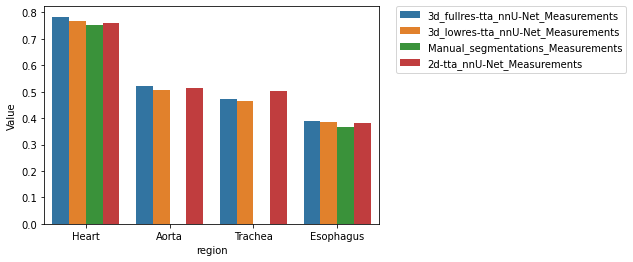

In [ ]:
# For each region, plot a bar chart of the features for manual + 3 predicted models 

sns.barplot(data=radiomics_df, x="region", y="Value", hue="SeriesDescription")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


### (paper figure #4) NSCLC Radiomics - Extract a single feature for all subjects and a single region

We also demonstrate how to extract a single feature for all subjects for a single region. We then plot the distributions of the features for the manual segmentations and the three nnU-Net predicted models. We link the OHIF viewer to further investigate any possible outliers.

In [ ]:
# Query to get a single feature for all subjects/series for a single region

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) # later will change to use idc_current. 
print(table_id)

region = "Heart"

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    Value  
  FROM 
    `bigquery-public-data.idc_current.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
    findingSite.CodeMeaning = @region
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nsclc_radiomics" 
ORDER BY 
  dicom_all.PatientID, 
  features.sourceSegmentedSeriesUID 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_current.quantitative_measurements


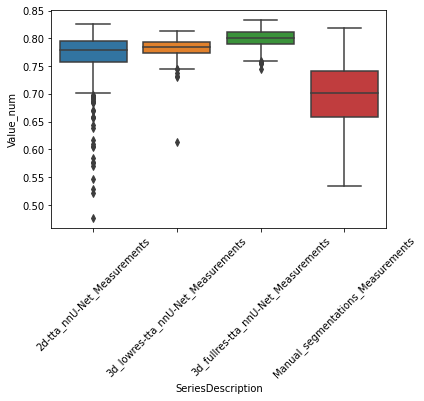

In [ ]:
# Plot the distributions of the features for the manual + 3 predicted models 

radiomics_df["Value_num"] = [np.float16(f) for f in radiomics_df["Value"]]
ax = sns.boxplot(data=radiomics_df, x="SeriesDescription", y="Value_num")
ax.tick_params(axis='x', rotation=45)

In [ ]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row


In [ ]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

In [ ]:
# Link of OHIF url for the above 

# SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
# num_SeriesDescriptions = len(SeriesDescriptions_list)
# print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

###########################################################
# --- Create a plot for each feature - just 1 for now --- #
###########################################################

#--- create df of the feature we want to plot ---# 

df_plot = radiomics_df
new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
num_SeriesDescriptions = len(SeriesDescriptions_list)
print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

#--- Plot using bokeh ---# 

output_notebook()

hover = HoverTool(tooltips=[
  (''.join(["(",'Sphericity',")"]), "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'SeriesDescription')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
SeriesDescriptions = colormap_list_keys 
print('SeriesDescriptions: ' + str(SeriesDescriptions))

# cats = df_plot.measurementGroup_number_region.unique()
cats = df_plot.SeriesDescription.unique()
print('cats: ' + str(cats))

colors = list(colormap.values())
print('colors: ' + str(colors))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          # x_range=cats,
            x_range=SeriesDescriptions,
          title='Sphericity')

p.circle(y='Value_numeric', x=jitter('SeriesDescription', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')


### Include the box plots ### 
# find the quartiles and IQR for each category
# groups = df_plot.groupby('regions')
# groups = df_plot.groupby('measurementGroup_number_str')
# groups = df_plot.groupby('measurementGroup_number_str')

# regions are in order we want 
category_SeriesDescription = pd.api.types.CategoricalDtype(categories=SeriesDescriptions, ordered=True)
df_plot['SeriesDescription'] = df_plot['SeriesDescription'].astype(category_SeriesDescription)

groups = df_plot.groupby('SeriesDescription')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric, 
    fill_color=colors,
    legend=cats
))

lower_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q1.Value_numeric, 
    top=q2.Value_numeric,
    fill_color=colors
))


# p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# stems (Don't need colors of treatment)
p.segment(cats, upper.Value_numeric, cats, q3.Value_numeric, line_color="black")
p.segment(cats, lower.Value_numeric, cats, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
# p.rect(cats, lower.Value_numeric, 0.2, 0.01, line_color="black")
# p.rect(cats, upper.Value_numeric, 0.2, 0.01, line_color="black")
p.rect(cats, lower.Value_numeric, 0.2, 0.0001, line_color="black")
p.rect(cats, upper.Value_numeric, 0.2, 0.0001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p.add_layout(legend, 'below')    
# p.add_layout(legend, 'right')

# Setup plot titles and such.
p.title.text = 'Sphericity'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "nnUNet model"
p.yaxis.axis_label="Sphericity"
# p.legend.location = (100,10)



url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

num_SeriesDescriptions: 4
check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'2d-tta_nnU-Net_Measurements': '#1b9e77', '3d_lowres-tta_nnU-Net_Measurements': '#d95f02', '3d_fullres-tta_nnU-Net_Measurements': '#7570b3', 'Manual_segmentations_Measurements': '#e7298a'}
colormap_list_keys: ['2d-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
SeriesDescriptions: ['2d-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
cats: ['2d-tta_nnU-Net_Measurements' '3d_lowres-tta_nnU-Net_Measurements'
 '3d_fullres-tta_nnU-Net_Measurements' 'Manual_segmentations_Measurements']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Download a DICOM Structured Report for one subject

In [ ]:
radiomics_df

,sourceSegmentedSeriesUID,SOPInstanceUID,StudyInstanceUID,PatientID,SeriesDescription,Value,viewer_url,Value_num,Value_numeric,colors
0,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.468135.16657...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,2d-tta_nnU-Net_Measurements,0.744000000,https://viewer.imaging.datacommons.cancer.gov/...,0.744141,0.744,#1b9e77
1,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.183145.16656...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,3d_lowres-tta_nnU-Net_Measurements,0.788000000,https://viewer.imaging.datacommons.cancer.gov/...,0.788086,0.788,#d95f02
2,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.2.276.0.7230010.3.1.4.481034752.147481.16643...,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,LUNG1-001,3d_fullres-tta_nnU-Net_Measurements,0.797000000,https://viewer.imaging.datacommons.cancer.gov/...,0.796875,0.797,#7570b3
3,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.2.276.0.7230010.3.1.4.481037312.51276.167148...,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,LUNG1-002,Manual_segmentations_Measurements,0.753000000,https://viewer.imaging.datacommons.cancer.gov/...,0.752930,0.753,#e7298a
4,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.2.276.0.7230010.3.1.4.481034752.112553.16656...,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,LUNG1-002,3d_lowres-tta_nnU-Net_Measurements,0.769000000,https://viewer.imaging.datacommons.cancer.gov/...,0.769043,0.769,#d95f02
...,...,...,...,...,...,...,...,...,...,...
1359,1.3.6.1.4.1.32722.99.99.3051646366712319699947...,1.2.276.0.7230010.3.1.4.481034752.187281.16656...,1.3.6.1.4.1.32722.99.99.9487282134711408248112...,LUNG1-421,3d_lowres-tta_nnU-Net_Measurements,0.800000000,https://viewer.imaging.datacommons.cancer.gov/...,0.799805,0.800,#d95f02
1360,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.115316.16656...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,3d_lowres-tta_nnU-Net_Measurements,0.766000000,https://viewer.imaging.datacommons.cancer.gov/...,0.766113,0.766,#d95f02
1361,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.401483.16657...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,2d-tta_nnU-Net_Measurements,0.771000000,https://viewer.imaging.datacommons.cancer.gov/...,0.770996,0.771,#1b9e77
1362,1.3.6.1.4.1.32722.99.99.2350774061601826088292...,1.2.276.0.7230010.3.1.4.481034752.71671.166429...,1.3.6.1.4.1.32722.99.99.3228297855554221494057...,LUNG1-422,3d_fullres-tta_nnU-Net_Measurements,0.788000000,https://viewer.imaging.datacommons.cancer.gov/...,0.788086,0.788,#7570b3


In [ ]:
# Pick a single Radiomics SR from previous df 

# sourceSegmentedSeriesUID = radiomics_df['sourceSegmentedSeriesUID'].values[0] 
SOPInstanceUID = radiomics_df['SOPInstanceUID'].values[0]
SOPInstanceUID

'1.2.276.0.7230010.3.1.4.481034752.468135.1665722540.260168'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

,SeriesDescription,gcs_url
0,2d-tta_nnU-Net_Measurements,gs://public-datasets-idc/4344dae8-58de-4f8e-8c...


In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm...
/ [1/1 files][168.3 KiB/168.3 KiB] 100% Done                                    
Operation completed over 1 objects/168.3 KiB.                                    
/content/sr/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm
/content/sr/sr.dcm


'/content/sr/sr.dcm'

### Use highdicom to extract relevant fields from the SR

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

features_sr_df = pd.DataFrame() 

segment_names = [] 
segment_numbers = [] 

feature_name_values = [] 
feature_name_codes = [] 
feature_name_meanings = [] 

feature_unit_values = [] 
feature_unit_codes = [] 
feature_unit_meanings = [] 

values = [] 
ref_seg_sop_ids = [] 

features_sr_df = pd.DataFrame() 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS,
    value_type=ValueTypeValues.CONTAINER,
    name=codes.DCM.ImagingMeasurements
)

containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS
)
num_segments = len(containers_level2)
print('num_segments: ' + str(num_segments))

for segment_index in range(0,num_segments): 

  print('segment_index: ' + str(segment_index))

  # For each segment in num_segments, get the segment_name, segment_number, and referencedsegmentSOPInstanceUID  
  containers_level2A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD,
      value_type=ValueTypeValues.CODE
  )

  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # print('   segment_name: ' + str(segment_name))

  containers_level3A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.IMAGE
  )

  segment_number = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSegmentNumber
  ref_seg_sop_id = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   segment_number: ' + str(segment_number))
  # print('   ref_seg_sop_id: ' + str(ref_seg_sop_id))

  ### The below works, just need to get segment info first ### 
  containers_level3 = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.NUM
  )
  num_features = len(containers_level3)
  # print('   num_features: ' + str(num_features))

  for feature_index in range(0,num_features):

    feature_name_value = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeValue'].value
    feature_name_code = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodingSchemeDesignator'].value
    feature_name_meaning = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeMeaning'].value
    # print('      feature_name_value: ' + str(feature_name_value) + ' feature_name_code: ' + str(feature_name_code) + 'feature_name_meaning: ' + str(feature_name_meaning))

    feature_unit_value = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeValue'].value
    feature_unit_code = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodingSchemeDesignator'].value
    feature_unit_meaning = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeMeaning'].value
    # print('      feature_unit_value: ' + str(feature_unit_value) + ' feature_unit_code: ' + str(feature_unit_code) + 'feature_unit_meaning: ' + str(feature_unit_meaning))

    value = containers_level3[feature_index].MeasuredValueSequence[0].NumericValue
    # print('      value: ' + str(value))

    # Append for all 
    segment_numbers.append(segment_number)
    segment_names.append(segment_name)
    feature_name_values.append(feature_name_value)
    feature_name_codes.append(feature_name_code) 
    feature_name_meanings.append(feature_name_meaning)
    feature_unit_values.append(feature_unit_value) 
    feature_unit_codes.append(feature_unit_code)
    feature_unit_meanings.append(feature_unit_meaning)
    values.append(value)
    ref_seg_sop_ids.append(ref_seg_sop_id)



# Form dataframe 

features_sr_df['segment_number'] = segment_numbers 
features_sr_df['segment_name'] = segment_name

features_sr_df['feature_name_value'] = feature_name_values 
features_sr_df['feature_name_code'] = feature_name_codes 
features_sr_df['feature_name_meaning'] = feature_name_meanings

features_sr_df['feature_unit_value'] = feature_unit_values 
features_sr_df['feature_unit_code'] = feature_unit_codes
features_sr_df['features_unit_meaning'] = feature_unit_meanings 

features_sr_df['value'] = values 

features_sr_df['ref_sop_id'] = ref_seg_sop_ids 

features_sr_df 

sr_file: /content/sr/sr.dcm
num_segments: 4
segment_index: 0
segment_index: 1
segment_index: 2
segment_index: 3


,segment_number,segment_name,feature_name_value,feature_name_code,feature_name_meaning,feature_unit_value,feature_unit_code,features_unit_meaning,value,ref_sop_id
0,1,Aorta,Q3CK,IBSI,Elongation,mm,UCUM,millimeter,0.187,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
1,1,Aorta,N17B,IBSI,Flatness,mm,UCUM,millimeter,0.105,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
2,1,Aorta,7J51,IBSI,Least Axis in 3D Length,mm,UCUM,millimeter,31.371,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
3,1,Aorta,TDIC,IBSI,Major Axis in 3D Length,mm,UCUM,millimeter,299.403,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
4,1,Aorta,L0JK,IBSI,Maximum 3D Diameter of a Mesh,mm,UCUM,millimeter,244.741,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
5,1,Aorta,RNU0,IBSI,Volume of Mesh,mm3,UCUM,cubic millimeter,45285.702,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
6,1,Aorta,P9VJ,IBSI,Minor Axis in 3D Length,mm,UCUM,millimeter,56.044,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
7,1,Aorta,QCFX,IBSI,Sphericity,1,UCUM,no units,0.396,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
8,1,Aorta,C0JK,IBSI,Surface Area of Mesh,mm2,UCUM,square millimeter,15531.507,1.2.276.0.7230010.3.1.4.481034752.467623.16657...
9,1,Aorta,2PR5,IBSI,Surface to Volume Ratio,/mm,UCUM,per millimeter,0.343,1.2.276.0.7230010.3.1.4.481034752.467623.16657...


### Use dcmqi to read the SR

In [ ]:
output_directory_sr_features_converted_dcmqi = "/content/sr_features_dcmqi"
if not os.path.isdir(output_directory_sr_features_converted_dcmqi): 
  os.mkdir(output_directory_sr_features_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_features_converted_dcmqi, "sr_features.json")

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'Finding': {'CodeMeaning': 'Organ',
    'CodeValue': '113343008',
    'CodingSchemeDesignator': 'SCT'},
   'FindingSite': {'CodeMeaning': 'Esophagus',
    'CodeValue': '32849002',
    'CodingSchemeDesignator': 'SCT'},
   'ReferencedSegment': 1,
   'SourceSeriesForImageSegmentation': '1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046',
   'TrackingIdentifier': 'Measurements group 1',
   'TrackingUniqueIdentifier': '1.3.6.1.4.1.43046.3.1.4.481034752.468135.1665722540.260164',
   'activitySession': '1',
   'measurementItems': [{'measurementAlgorithmIdentification': {'AlgorithmName': 'pyradiomics',
      'AlgorithmVersion': 'v3.0.1'},
     'quantity': {'CodeMeaning': 'Elongation',
      'CodeValue': 'Q3CK',
      'CodingSchemeDesignator': 'IBSI'},
     'units': {'CodeMeaning': 'millimeter',
      'CodeValue': 'mm',
      'CodingSchemeDesignator': 'UCUM'},
     'value': '0.187'},
    {'measurementAlgorit

# Body Part Prediction results analysis

## Landmarks analysis

### Query and extract values from the landmarks SR and plot 

We first get a list of all the possible landmarks from the csv file. 

In [ ]:
!wget -N https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
landmarks_df = pd.read_csv("bpr_landmarks_code_mapping.csv")

--2023-03-16 18:46:00--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797 (1.8K) [text/plain]
Saving to: ‘bpr_landmarks_code_mapping.csv’

bpr_landmarks_code_ 100%[===================>]   1.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-03-16 18:46:00 (21.7 MB/s) - ‘bpr_landmarks_code_mapping.csv’ saved [1797/1797]



We then need to download the public BPR model from Zenodo and get the inference-settings.json file as we need the ordering of the landmarks from inferior to superior. 

In [ ]:
bpr_model_url = "https://zenodo.org/record/5113483/files/public_bpr_model.zip"
model_download_path = "/content/models/bpr_model.zip"
if not os.path.isdir("/content/models"):
  os.mkdir("/content/models")

!wget -O $model_download_path $bpr_model_url 

model_extract_path = "/content/models/bpr_model"
!unzip $model_download_path -d $model_extract_path

--2023-03-16 15:37:49--  https://zenodo.org/record/5113483/files/public_bpr_model.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55645041 (53M) [application/octet-stream]
Saving to: ‘/content/models/bpr_model.zip’

/content/models/bpr 100%[===================>]  53.07M  1.05MB/s    in 61s     

2023-03-16 15:38:52 (889 KB/s) - ‘/content/models/bpr_model.zip’ saved [55645041/55645041]

Archive:  /content/models/bpr_model.zip
   creating: /content/models/bpr_model/public_bpr_model/
  inflating: /content/models/bpr_model/public_bpr_model/reference.xlsx  
  inflating: /content/models/bpr_model/public_bpr_model/inference-settings.json  
  inflating: /content/models/bpr_model/public_bpr_model/model.pt  
  inflating: /content/models/bpr_model/public_bpr_model/config.json  


Let's get the data from the inference-settings.json file. 

In [ ]:
inference_settings_file = "/content/models/bpr_model/public_bpr_model/inference-settings.json" 
with open(inference_settings_file) as f: 
  inference_settings_json = json.load(f)

landmarks_inference = inference_settings_json['lookuptable_train_val']['transformed']

# create new dictionary with ordered landmarks 
landmarks_inference_sorted = dict(sorted(landmarks_inference.items(), key=lambda item: item[1]['mean'])) 

In [ ]:
# Create a dataframe with the landmarks_inference_sorted 

landmarks_inference_sorted_df = pd.DataFrame() 
landmarks_inference_sorted_df['landmark'] = landmarks_inference_sorted.keys() 
landmarks_inference_sorted_df['mean'] = [landmarks_inference_sorted[f]['mean'] for f in landmarks_inference_sorted.keys()]
landmarks_inference_sorted_df['std'] = [landmarks_inference_sorted[f]['std'] for f in landmarks_inference_sorted.keys()]

# To this dataframe we add the corresponding fields from landmarks_df, in the correct order
num_codes = len(landmarks_inference_sorted_df)
landmark_CodeMeanings = [] 
modifier_CodeMeanings = [] 

# for each 
for n in range(0,num_codes): 
  bpr_code = landmarks_inference_sorted_df['landmark'].values[n]
  landmark_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['CodeMeaning'].values[0]
  modifier_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['modifier_CodeMeaning'].values[0]
  landmark_CodeMeanings.append(landmark_CodeMeaning)
  modifier_CodeMeanings.append(modifier_CodeMeaning)

landmarks_inference_sorted_df['landmark_CodeMeaning'] = landmark_CodeMeanings 
landmarks_inference_sorted_df['modifier_CodeMeaning'] = modifier_CodeMeanings 
landmarks_inference_sorted_df['landmark_and_modifier_name'] = [f + ' ' + g for f,g in zip(landmark_CodeMeanings,modifier_CodeMeanings)]

In [ ]:
landmarks_inference_sorted_df

,landmark,mean,std,landmark_CodeMeaning,modifier_CodeMeaning,landmark_and_modifier_name
0,pelvis_start,0.000,1.983,Pelvis,Bottom,Pelvis Bottom
1,femur_end,13.616,1.198,Femur,Top,Femur Top
2,L5,25.532,1.854,L5 vertebra,Center,L5 vertebra Center
3,pelvis_end,28.824,1.881,Pelvis,Top,Pelvis Top
4,L4,29.414,2.098,L4 vertebra,Center,L4 vertebra Center
5,L3,33.817,2.290,L3 vertebra,Center,L3 vertebra Center
6,kidney,37.597,4.116,Kidney,Bottom,Kidney Bottom
7,L2,37.763,2.335,L2 vertebra,Center,L2 vertebra Center
8,L1,41.478,2.276,L1 vertebra,Center,L1 vertebra Center
9,lung_start,44.143,4.385,Lung,Bottom,Lung Bottom


We then query to get the landmarks for NSCLC-Radiomics. 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


We need to form a dataframe with just the landmarks/regions. 

In [ ]:
# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

Let's pick a single seriesInstanceUID

In [ ]:

series_ids = list(set(list(landmarks_series_df['crpes_ref'].values)))
# series_ids_keep = series_ids[0:3]
# print(series_ids_keep)
series_id = series_ids[0] 
print(series_id)

# landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin(series_ids_keep)]
# landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin([series_ids])]
landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"]==series_id]

1.3.6.1.4.1.32722.99.99.286714454369710809238330584946086450994


In order to form the overlay pictures, we need to get the original CT files. We will need to get the IPP in order to get the actual axial slice index that each landmark corresponds to. We have the referencedSOPInstanceUID. 

In [ ]:
# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

all_ct_series_df = pd.DataFrame()

# for n in range(0,3): 

### Query to get gcs_urls ### 

# series_id = series_ids_keep[n]
client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
all_ct_series_df = pd.concat([all_ct_series_df,series_df])

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_sop = len(all_ct_series_df)
SOPInstanceUIDs = list(all_ct_series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  all_ct_series_df_temp = all_ct_series_df[all_ct_series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = all_ct_series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = all_ct_series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])



Copying gs://idc-open-cr/4f238705-6208-4e0d-9c9d-bfbcea1bf5e9.dcm...
Copying gs://idc-open-cr/4d228d1d-d99e-4d91-8d54-907478c1b1d4.dcm...
Copying gs://idc-open-cr/21ad6de7-9dbb-4bde-bb23-2f569a879004.dcm...
Copying gs://idc-open-cr/1acaf5b6-b287-4b07-a4bc-587887364eb0.dcm...
Copying gs://idc-open-cr/d8f3b82a-4d2d-48f3-80d2-5fb1911e4075.dcm...
Copying gs://idc-open-cr/8e5667f4-cd88-45fc-ba83-2bf073d41cfe.dcm...
Copying gs://idc-open-cr/e2335c0d-9722-4dfa-8730-2d1e37ce72c8.dcm...
Copying gs://idc-open-cr/dcd9d3b2-0a85-4061-92ba-23c8e0305fd9.dcm...
Copying gs://idc-open-cr/1e0db447-746d-44c8-9a02-7cc5c2b40ce4.dcm...
Copying gs://idc-open-cr/dc70176e-b346-432c-8b14-bd5dcd3c9f7c.dcm...
Copying gs://idc-open-cr/7fb4a2da-1546-42f0-a24f-b80f68ce71a9.dcm...
Copying gs://idc-open-cr/7d5b71fc-de2b-487a-8115-50a1d694f1f8.dcm...
Copying gs://idc-open-cr/b0d56657-1584-490d-a546-7920817ca9fa.dcm...
Copying gs://idc-open-cr/20dabbe2-ff2e-4809-8a45-24a161627efa.dcm...
Copying gs://idc-open-cr/20a60fe2-

Reorder the rows from min and max and add the index value. 

In [ ]:
# all_ct_series_df['pos'] = pos_all 
series_df['pos'] = pos_all

### Reorder rows from min to max and put index value ### 
series_df = series_df.sort_values(by=['pos'])

series_df = series_df.sort_values(by=['pos'])
slice_index = range(0,len(series_df))
series_df['slice_index'] = slice_index 
series_df 

# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# slice_index = range(0,len(series_df))
# series_df['slice_index'] = slice_index
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])

,SeriesInstanceUID,SOPInstanceUID,gcs_url,ImagePositionPatient,ImageOrientationPatient,PixelSpacing,pos,slice_index
87,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.3161718301880190406013...,gs://idc-open-cr/7fecf333-0162-422e-a52b-80234...,-249.51171875/-419.51171875/-747.5,1/0/0/0/1/0,0.9765625/0.9765625,-747.5,0
126,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.2282913668506062389546...,gs://idc-open-cr/5e78bc45-da04-4205-bee3-49f7f...,-249.51171875/-419.51171875/-744.5,1/0/0/0/1/0,0.9765625/0.9765625,-744.5,1
109,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.2549092535801997300830...,gs://idc-open-cr/69fa9671-974a-4f45-94de-6810e...,-249.51171875/-419.51171875/-741.5,1/0/0/0/1/0,0.9765625/0.9765625,-741.5,2
113,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.6993484434803817526529...,gs://idc-open-cr/5e73920a-b15c-47fb-b85d-d6550...,-249.51171875/-419.51171875/-738.5,1/0/0/0/1/0,0.9765625/0.9765625,-738.5,3
63,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.1858024035499569559882...,gs://idc-open-cr/4129aef7-4025-42c2-b185-a1628...,-249.51171875/-419.51171875/-735.5,1/0/0/0/1/0,0.9765625/0.9765625,-735.5,4
...,...,...,...,...,...,...,...,...
111,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.1394322418971856264150...,gs://idc-open-cr/3c35b6bf-23ca-4ff9-a3c3-d2b12...,-249.51171875/-419.51171875/-360.5,1/0/0/0/1/0,0.9765625/0.9765625,-360.5,129
108,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.4050054187409238534890...,gs://idc-open-cr/7a94860e-a6e2-44af-9740-60c67...,-249.51171875/-419.51171875/-357.5,1/0/0/0/1/0,0.9765625/0.9765625,-357.5,130
81,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.8258511880649750164641...,gs://idc-open-cr/6f245fc2-49c2-453f-8bf2-3dcaa...,-249.51171875/-419.51171875/-354.5,1/0/0/0/1/0,0.9765625/0.9765625,-354.5,131
57,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.1046354343112241226007...,gs://idc-open-cr/7311d266-9ac2-43ff-956f-5f7de...,-249.51171875/-419.51171875/-351.5,1/0/0/0/1/0,0.9765625/0.9765625,-351.5,132


To the landmarks_series_df, add the index value of the actual axial slice index it corresponds to, based on the SOPInstanceUID and which one it matches to the original CT files. 

In [ ]:
num_sop = len(landmarks_series_df_keep)

# for each sourceReferencedSOPInstanceUID in the landmarks_single_series_df, get the index value in the series_df 
landmark_axial_indices = [] 
for n in range(0,num_sop): 
  sourceReferencedSOPInstanceUID = landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values[n]
  landmark_axial_index = series_df[series_df['SOPInstanceUID']==sourceReferencedSOPInstanceUID]['slice_index'].values[0]
  landmark_axial_indices.append(landmark_axial_index)

landmarks_series_df_keep['slice_index'] = landmark_axial_indices

Add the unnested names of the landmarks to the dataframe 

In [ ]:
# # Now add the three columns to landmarks_series_df
# landmarks_series_df_keep['ImagePositionPatient'] = ImagePositionPatient_all 
# landmarks_series_df_keep['ImageOrientationPatient'] = ImageOrientationPatient_all 
# landmarks_series_df_keep['pos'] = pos_all

# Add the names of the landmarks as well 
series_landmarks_site = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]
landmarks_series_df_keep['landmark_names'] = series_landmarks
landmarks_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,segmentationSegmentNumber,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref,slice_index,landmark_names
183708,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,0,1.2.826.0.1.3680043.8.498.20172256717110165336...,Annotations group landmarks 1,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1260682354669239540224...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '36470004', 'CodingSchemeDesigna...",None,"{'CodeValue': '36470004', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,6,L3 vertebra Center
183709,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,1,1.2.826.0.1.3680043.8.498.84306092710314342931...,Annotations group landmarks 2,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.8795242571237577623561...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '64033007', 'CodingSchemeDesigna...",None,"{'CodeValue': '64033007', 'CodingSchemeDesigna...","{'CodeValue': '42161009', 'CodingSchemeDesigna...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,17,Kidney Bottom
183710,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,2,1.2.826.0.1.3680043.8.498.53798985479637531123...,Annotations group landmarks 3,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2088802042462991717024...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '14293000', 'CodingSchemeDesigna...",None,"{'CodeValue': '14293000', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,18,L2 vertebra Center
183711,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,3,1.2.826.0.1.3680043.8.498.76992089997921484924...,Annotations group landmarks 4,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1200590338525463145382...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '66794005', 'CodingSchemeDesigna...",None,"{'CodeValue': '66794005', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,30,L1 vertebra Center
183712,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,4,1.2.826.0.1.3680043.8.498.24268892783752047845...,Annotations group landmarks 5,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3060330209484120001017...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '39607008', 'CodingSchemeDesigna...",None,"{'CodeValue': '39607008', 'CodingSchemeDesigna...","{'CodeValue': '421610009', 'CodingSchemeDesign...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,38,Lung Bottom
183713,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,5,1.2.826.0.1.3680043.8.498.12179494845810221732...,Annotations group landmarks 6,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3326395177409673026043...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '23215003', 'CodingSchemeDesigna...",None,"{'CodeValue': '23215003', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.2867144543697108092383...,40,T12 vertebra Center
183714,1.2.826.0.1.3680043.8.498.28495371806652085857...,1.2.826.0.1.3680043.8.498.71753374453839344167...,6,1.2.826.0.1.3680043.8.498.13046745540145011423...,Annotations group landmarks 7,LUNG1-405,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3055209195580763842400...,None,[],"{'CodeValue': '36

Now we can plot the landmarks on a coronal slice 

Option 1: lines across in white 

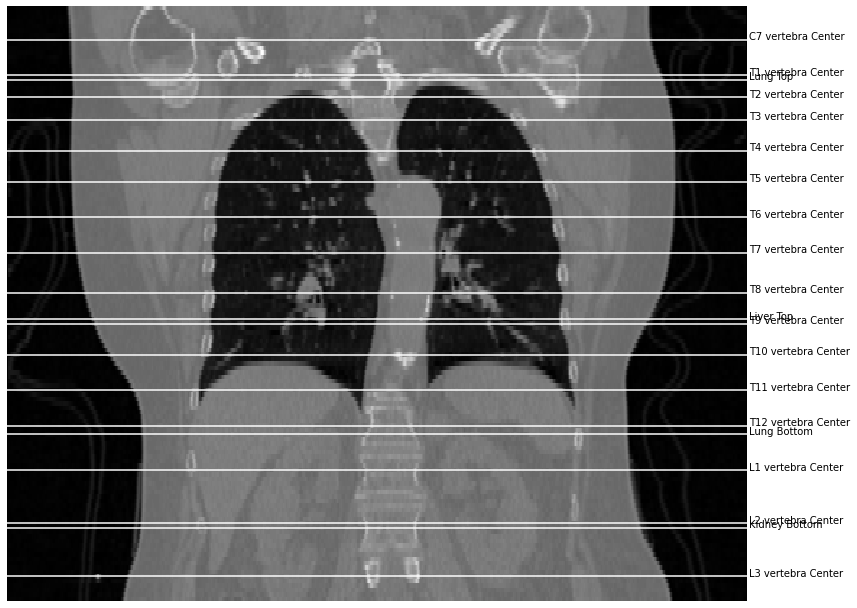

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  plt.axhline(y=slice_index, color='w', linestyle='-')

  plt.annotate(landmark_name, xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

Option 2: small lines on one side 

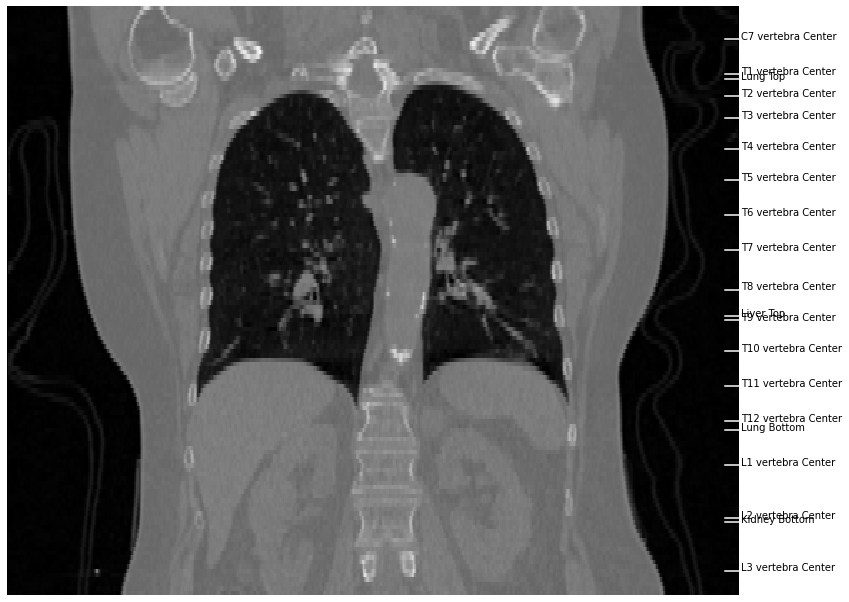

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  # plt.axhline(y=slice_index, color='w', linestyle='-')

  # plt.annotate(landmark_name,(dim[0],slice_index)) 
  plt.plot([dim[0]-10, dim[0]+10], 
        [slice_index, slice_index],
        color='w', 
        linestyle='-')
  plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

Option 3: small lines on either side, right has anything with center modifier and left has top/bottom modifiers 

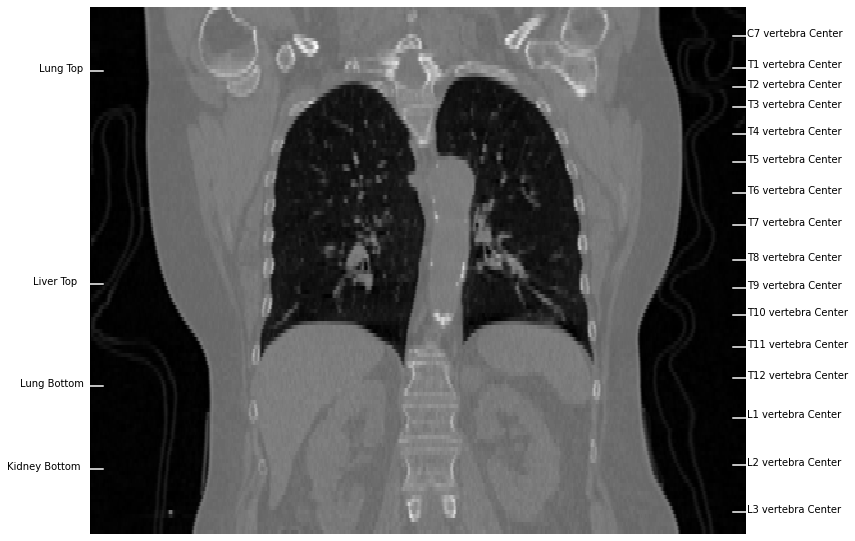

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(6,8)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  # plt.axhline(y=slice_index, color='w', linestyle='-')

  # plt.annotate(landmark_name,(dim[0],slice_index))
  if (('Bottom' in landmark_name) or ('Top' in landmark_name)):
    plt.plot([-10, 10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    # plt.annotate(landmark_name,xy=(-60,slice_index), xycoords='data',annotation_clip=False)
    plt.annotate(landmark_name,xy=(len(landmark_name)*-5,slice_index), xycoords='data',annotation_clip=False)

  else: 
    plt.plot([dim[0]-10, dim[0]+10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

(134, 512)


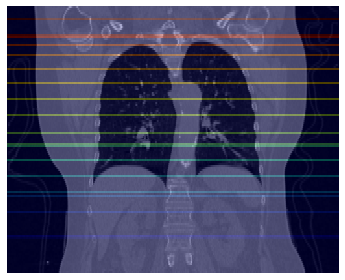

In [ ]:
# ct_df_plot = series_df 
# landmarks_df_plot = landmarks_series_df_keep

# # Get the center coronal slice from the CT volume 
# ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
# nii = nib.load(ct_nii)
# img = nii.get_fdata() 
# dim = img.shape 
# pixel_spacing = nii.header['pixdim'][1:4]
# coronal_slice_index = np.uint16(np.floor(dim[1]/2))
# coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
# coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

# from matplotlib import cm
# num_landmarks = len(landmarks_inference_sorted)
# viridis = cm.get_cmap('viridis', num_landmarks)
# # Create overlay labelmap 
# landmarks_array = np.zeros((dim[2], dim[0]))
# print(landmarks_array.shape)

# slice_indices = landmarks_df_plot['slice_index'].values

# for m in range(0,len(slice_indices)): 
#   # landmarks_array[slice_indices[m],:] = m
#   # later use index from where the landmark appears in the list - want the same colors across subjects 
#   landmarks_array[slice_indices[m],:] = m
# # flip
# landmarks_array = np.flipud(landmarks_array) # because of plotting 

# fig, ax = plt.subplots(1, 1)
# # ax.imshow(coronal_slice_rotated, cmap='gray', vmax=1500, vmin=-1000, aspect="auto")
# # ax.imshow(landmarks_array, cmap='OrRd', aspect="auto", alpha=0.5, interpolation='none')

# plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# plt.imshow(landmarks_array, 'jet', interpolation='none', alpha=0.3)


# cor_aspect = pixel_spacing[2]/pixel_spacing[0]
# ax.set_aspect(cor_aspect)
# # plt.gca().invert_yaxis()
# plt.axis('off')
# fig = ax.get_figure()
# fig.tight_layout()
# # plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
# plt.show() 




### OLD - DELETE LATER - Query and extract values from landmarks SR and plot

We first get a list of all the possible landmarks from the csv file. 

In [ ]:
!wget -N https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
landmarks_df = pd.read_csv("bpr_landmarks_code_mapping.csv")

--2023-03-16 15:37:49--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797 (1.8K) [text/plain]
Saving to: ‘bpr_landmarks_code_mapping.csv’

bpr_landmarks_code_ 100%[===================>]   1.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-03-16 15:37:49 (30.2 MB/s) - ‘bpr_landmarks_code_mapping.csv’ saved [1797/1797]



We then need to download the public BPR model from Zenodo and get the inference-settings.json file as we need the ordering of the landmarks from inferior to superior. 

In [ ]:
bpr_model_url = "https://zenodo.org/record/5113483/files/public_bpr_model.zip"
model_download_path = "/content/models/bpr_model.zip"
if not os.path.isdir("/content/models"):
  os.mkdir("/content/models")

!wget -O $model_download_path $bpr_model_url 

model_extract_path = "/content/models/bpr_model"
!unzip $model_download_path -d $model_extract_path

--2023-03-16 15:37:49--  https://zenodo.org/record/5113483/files/public_bpr_model.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55645041 (53M) [application/octet-stream]
Saving to: ‘/content/models/bpr_model.zip’

/content/models/bpr 100%[===================>]  53.07M  1.05MB/s    in 61s     

2023-03-16 15:38:52 (889 KB/s) - ‘/content/models/bpr_model.zip’ saved [55645041/55645041]

Archive:  /content/models/bpr_model.zip
   creating: /content/models/bpr_model/public_bpr_model/
  inflating: /content/models/bpr_model/public_bpr_model/reference.xlsx  
  inflating: /content/models/bpr_model/public_bpr_model/inference-settings.json  
  inflating: /content/models/bpr_model/public_bpr_model/model.pt  
  inflating: /content/models/bpr_model/public_bpr_model/config.json  


Let's get the data from the inference-settings.json file. 

In [ ]:
inference_settings_file = "/content/models/bpr_model/public_bpr_model/inference-settings.json" 
with open(inference_settings_file) as f: 
  inference_settings_json = json.load(f)

landmarks_inference = inference_settings_json['lookuptable_train_val']['transformed']

# create new dictionary with ordered landmarks 
landmarks_inference_sorted = dict(sorted(landmarks_inference.items(), key=lambda item: item[1]['mean'])) 
landmarks_inference_sorted

{'pelvis_start': {'mean': 0.0, 'std': 1.983},
 'femur_end': {'mean': 13.616, 'std': 1.198},
 'L5': {'mean': 25.532, 'std': 1.854},
 'pelvis_end': {'mean': 28.824, 'std': 1.881},
 'L4': {'mean': 29.414, 'std': 2.098},
 'L3': {'mean': 33.817, 'std': 2.29},
 'kidney': {'mean': 37.597, 'std': 4.116},
 'L2': {'mean': 37.763, 'std': 2.335},
 'L1': {'mean': 41.478, 'std': 2.276},
 'lung_start': {'mean': 44.143, 'std': 4.385},
 'Th12': {'mean': 44.952, 'std': 2.287},
 'Th11': {'mean': 47.725, 'std': 2.503},
 'Th10': {'mean': 51.069, 'std': 2.717},
 'Th9': {'mean': 53.994, 'std': 2.613},
 'liver_end': {'mean': 54.479, 'std': 3.986},
 'Th8': {'mean': 56.856, 'std': 2.36},
 'Th7': {'mean': 59.851, 'std': 2.822},
 'Th6': {'mean': 63.177, 'std': 2.404},
 'Th5': {'mean': 65.964, 'std': 2.118},
 'Th4': {'mean': 68.499, 'std': 2.051},
 'Th3': {'mean': 70.973, 'std': 2.038},
 'Th2': {'mean': 73.401, 'std': 1.694},
 'lung_end': {'mean': 75.389, 'std': 1.478},
 'Th1': {'mean': 75.794, 'std': 1.811},
 'C7

We then query to get the landmarks for NSCLC-Radiomics. 

In [ ]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


We need to form a dataframe with just the landmarks/regions. 

In [ ]:
# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

Let's get a sample of 3 seriesInstanceUIDs. 

In [ ]:
# Get 3 seriesInstanceUIDs 

series_ids = list(set(list(landmarks_series_df['crpes_ref'].values)))
series_ids_keep = series_ids[0:3]
print(series_ids_keep)

landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin(series_ids_keep)]

['1.3.6.1.4.1.32722.99.99.148501964032128149026767525547142526917', '1.3.6.1.4.1.32722.99.99.249060917569692987140379861063884298344', '1.3.6.1.4.1.32722.99.99.240785272340649222855442419491436385642']


In order to form the overlay pictures, we need to get the original CT files. We will need to get the IPP in order to get the actual axial slice index that each landmark corresponds to. We have the referencedSOPInstanceUID. 

In [ ]:
# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

all_ct_series_df = pd.DataFrame()

for n in range(0,3): 

  ### Query to get gcs_urls ### 

  series_id = series_ids_keep[n]
  client = bigquery.Client(project=project_name)
  query = f"""
    SELECT 
      SeriesInstanceUID,
      SOPInstanceUID, 
      gcs_url,
      ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
      ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
      ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
    FROM
      `bigquery-public-data.idc_current.dicom_all` 
    WHERE
      SeriesInstanceUID = @series_id;
    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                        ])
  result = client.query(query, job_config=job_config) 
  series_df = result.to_dataframe(create_bqstorage_client=True)
  all_ct_series_df = pd.concat([all_ct_series_df,series_df])

  ### Download the gcs_urls ###

  # Create the text file to hold gsc_url 
  gs_file_path = "gcs_paths.txt"
  series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

  # Download the series 
  download_path_temp = "/content/raw_temp"
  if not os.path.isdir(download_path_temp):
    os.mkdir(download_path_temp)

  # !cat manifest.txt | gsutil -m cp -I .
  !cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

  ### Convert to nii ### 

  ct_nifti_directory_temp = "/content/ct_nii_temp" 
  if not os.path.isdir(ct_nifti_directory_temp): 
    os.mkdir(ct_nifti_directory_temp)

  cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
  print(cmd)
  ret = os.system(cmd)
  print(ret)

  # Rename file 

  nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
  nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
  if not os.path.isdir("/content/ct_qualitative"):
    os.mkdir("/content/ct_qualitative")
  os.rename(nii_file_orig, nii_file)

  ### Delete from folders ### 
  !rm -rf "/content/raw_temp"
  !rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_series = len(all_ct_series_df)
SOPInstanceUIDs = list(all_ct_series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = SOPInstanceUIDs[n] 
  all_ct_series_df_temp = all_ct_series_df[all_ct_series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = all_ct_series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = all_ct_series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

all_ct_series_df['pos'] = pos_all 


### For each series, reorder rows from min to max and put index value ### 

all_ct_series_df_ordered = pd.DataFrame() 

for n in range(0,3): 
  series_id = series_ids_keep[n]
  series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
  # order rows according to calculated pos 
  series_df = series_df.sort_values(by=['pos']) 
  # add an index value to the dataframe 
  all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])


Copying gs://idc-open-cr/3170954d-2e80-4822-a6dc-a0b3b84f2b79.dcm...
Copying gs://idc-open-cr/8c6b7d57-9bbc-47e0-abf7-d23f2772faa4.dcm...
Copying gs://idc-open-cr/d3a4d48a-38c2-499a-be0f-bc5a96adeaeb.dcm...
Copying gs://idc-open-cr/6f284368-4f27-46b2-b134-98ef1dfba9fe.dcm...
Copying gs://idc-open-cr/751f2afa-5ff6-43e4-a8e8-338ff06a81ce.dcm...
Copying gs://idc-open-cr/66b28ed7-b120-4152-b156-24a451034d43.dcm...
Copying gs://idc-open-cr/7ef5fd88-2722-410b-a0ab-79ffbeca4e90.dcm...
Copying gs://idc-open-cr/0dbca9dd-3849-4001-b67a-54eaac596c2b.dcm...
Copying gs://idc-open-cr/d635c9c9-b920-4e1f-a043-b18c3f409bf2.dcm...
Copying gs://idc-open-cr/7ef47f9b-d7e3-47d2-909f-d63686f01278.dcm...
Copying gs://idc-open-cr/76c6fcb4-2d3e-4291-b19e-56dbf3c159f1.dcm...
Copying gs://idc-open-cr/8d211aa5-cd70-4da1-a179-1d1dbd5fd1bf.dcm...
Copying gs://idc-open-cr/12fe893c-153d-4f2e-8cc6-1a5614294b34.dcm...
Copying gs://idc-open-cr/1ab96cf1-0302-468b-9c42-9548fd7fc5b1.dcm...
Copying gs://idc-open-cr/d28179e7-

In [ ]:
### For each series, reorder rows from min to max and put index value ### 

all_ct_series_df_ordered = pd.DataFrame() 

for n in range(0,3): 
  series_id = series_ids_keep[n]
  series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
  # order rows according to calculated pos 
  series_df = series_df.sort_values(by=['pos']) 
  # add an index value to the dataframe 
  slice_index = range(0,len(series_df))
  series_df['slice_index'] = slice_index
  all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])

In [ ]:
# Now for the landmarks, we also need to get the ImagePositionPatient, ImageOrientationPatient and 
# calculate the actual IPP and add to the dataframe landmarks_series_df. 

# Need to get the ImagePositionPatient and ImageOrientationPatient so I can map to actual slices. 
# ARRAY_TO_STRING(dicom_all.ImagePositionPatient,"/") AS ImagePositionPatient, 
# ARRAY_TO_STRING(dicom_all.ImageOrientationPatient, "/") AS ImageOrientationPatient

SOPInstanceUIDs = list(landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values)

client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SOPInstanceUID, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST (@SOPInstanceUIDs); 
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("SOPInstanceUIDs", "STRING", SOPInstanceUIDs)
                                                       ])
result = client.query(query_view, job_config=job_config) 
sop_df = result.to_dataframe(create_bqstorage_client=True)

In [ ]:
print(len(landmarks_series_df_keep))
print(len(sop_df))

51
51


In [ ]:
SOPInstanceUIDs = list(landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values)
num_series = len(SOPInstanceUIDs)
# SOPInstanceUIDs = sop_df['SOPInstanceUID']
# num_series = len(SOPInstanceUIDs) 

ImageOrientationPatient_all = [] 
ImagePositionPatient_all = [] 
pos_all = [] 

for n in range(0,num_series):
  
  sop_id = SOPInstanceUIDs[n] 
  sop_df_temp = sop_df[sop_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientationPatient_all.append(ImageOrientation)
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]

  ImagePositionPatient = sop_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient_all.append(ImagePositionPatient)
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# Now add the three columns to landmarks_series_df
landmarks_series_df_keep['ImagePositionPatient'] = ImagePositionPatient_all 
landmarks_series_df_keep['ImageOrientationPatient'] = ImageOrientationPatient_all 
landmarks_series_df_keep['pos'] = pos_all

# Add the names of the landmarks as well 
series_landmarks_site = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]
landmarks_series_df_keep['landmark_names'] = series_landmarks

landmarks_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,...,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref,ImagePositionPatient,ImageOrientationPatient,pos,landmark_names
9945,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,0,1.2.826.0.1.3680043.8.498.26738291939521329277...,Annotations group landmarks 1,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.9426555754633387105501...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '66794005', 'CodingSchemeDesigna...",None,"{'CodeValue': '66794005', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-662,1/0/0/0/1/0,-662.000000,L1 vertebra Center
9946,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,1,1.2.826.0.1.3680043.8.498.12365891064940342771...,Annotations group landmarks 2,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2894947859710068463910...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '39607008', 'CodingSchemeDesigna...",None,"{'CodeValue': '39607008', 'CodingSchemeDesigna...","{'CodeValue': '421610009', 'CodingSchemeDesign...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-635,1/0/0/0/1/0,-635.000000,Lung Bottom
9947,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,2,1.2.826.0.1.3680043.8.498.10282329914492072632...,Annotations group landmarks 3,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1357851099511947870363...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '23215003', 'CodingSchemeDesigna...",None,"{'CodeValue': '23215003', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-629,1/0/0/0/1/0,-629.000000,T12 vertebra Center
9948,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,3,1.2.826.0.1.3680043.8.498.11754401400071139419...,Annotations group landmarks 4,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1168644510372144907981...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '12989004', 'CodingSchemeDesigna...",None,"{'CodeValue': '12989004', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-605,1/0/0/0/1/0,-605.000000,T11 vertebra Center
9949,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,4,1.2.826.0.1.3680043.8.498.10894895814218697724...,Annotations group landmarks 5,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1666706683091259970733...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '7610001', 'CodingSchemeDesignat...",None,"{'CodeValue': '7610001', 'CodingSchemeDesignat...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-578,1/0/0/0/1/0,-578.000000,T10 vertebra Center
9950,1.2.826.0.1.3680043.8.498.26555334726307656960...,1.2.826.0.1.3680043.8.498.85098351770562859046...,5,1.2.826.0.1.3680043.8.498.61462709803863589300...,Annotations group landmarks 6,LUNG1-419,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3077211239318501208255...,None,...,"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '82687006', 'CodingSchemeDesigna...",None,"{'CodeValue': '82687006', 'CodingSchemeDesigna...","{'CodeValue': '111010', 'CodingSchemeDesignato...",1.3.6.1.4.1.32722.99.99.1485019640321281490267...,-249.51171875/-423.51171875/-55

(134, 512)


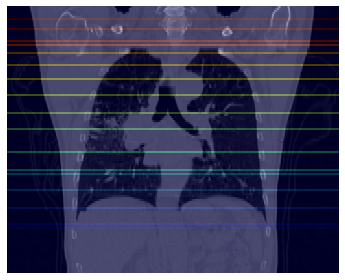

In [ ]:
# For each volume 

# for n in range(0,3): 
n=0

# CT and landmarks separate dataframes for the series
series_id = series_ids_keep[n]
ct_df_plot = all_ct_series_df_ordered[all_ct_series_df_ordered['SeriesInstanceUID']==series_id]
landmarks_df_plot = landmarks_series_df_keep[landmarks_series_df_keep['crpes_ref']==series_id]

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted)
viridis = cm.get_cmap('viridis', num_landmarks)
# Create overlay labelmap 
landmarks_array = np.zeros((dim[2], dim[0]))
print(landmarks_array.shape)

# now match the rows of landmarks_df_plot with the ct_df_plot and get the index values!
rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
# slice_indices = ct_df_plot['slice_index'][rows_match]                   
slice_indices = ct_df_plot.iloc[rows_match]['slice_index'].values # same as rows_match.


for m in range(0,len(slice_indices)): 
  # landmarks_array[slice_indices[m],:] = m
  # later use index from where the landmark appears in the list - want the same colors across subjects 
  landmarks_array[slice_indices[m],:] = m
# flip
landmarks_array = np.flipud(landmarks_array) # because of plotting 

fig, ax = plt.subplots(1, 1)
# ax.imshow(coronal_slice_rotated, cmap='gray', vmax=1500, vmin=-1000, aspect="auto")
# ax.imshow(landmarks_array, cmap='OrRd', aspect="auto", alpha=0.5, interpolation='none')

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
plt.imshow(landmarks_array, 'jet', interpolation='none', alpha=0.3)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
# plt.gca().invert_yaxis()
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
# plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.show() 

### We have two dataframes, one with CT position info and one with landmarks position info 
# landmark_z_indices = get_landmark_indices()

# # now match the rows of landmarks_df_plot with the ct_df_plot and get the index values!
# rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
# # slice_indices = ct_df_plot['slice_index'][rows_match]                   
# slice_indices = ct_df_plot.iloc[rows_match]['slice_index'].values # same as rows_match.

# Put row across with different color by order 
# colors from ordering in landmarks_inference_sorted

# Put label legend on side 



In [ ]:
ct_df_plot

,SeriesInstanceUID,SOPInstanceUID,gcs_url,ImagePositionPatient,ImageOrientationPatient,PixelSpacing,pos,slice_index
33,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.1540019099486668822640...,gs://idc-open-cr/0a2103b1-e259-47c4-a119-46828...,-249.51171875/-423.51171875/-701,1/0/0/0/1/0,0.9765625/0.9765625,-701.0,0
0,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.4891701350306356036895...,gs://idc-open-cr/3170954d-2e80-4822-a6dc-a0b3b...,-249.51171875/-423.51171875/-698,1/0/0/0/1/0,0.9765625/0.9765625,-698.0,1
64,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.4407280371866469331796...,gs://idc-open-cr/2faf9014-9ed1-4f66-890c-2a1b5...,-249.51171875/-423.51171875/-695,1/0/0/0/1/0,0.9765625/0.9765625,-695.0,2
125,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.1457560892040625740203...,gs://idc-open-cr/db2f31ab-4a59-4d50-a7cb-5ec05...,-249.51171875/-423.51171875/-692,1/0/0/0/1/0,0.9765625/0.9765625,-692.0,3
121,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.8920214981071205005808...,gs://idc-open-cr/3ebe4d8b-71ff-4522-938c-ad88b...,-249.51171875/-423.51171875/-689,1/0/0/0/1/0,0.9765625/0.9765625,-689.0,4
...,...,...,...,...,...,...,...,...
28,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.2745773571830823706425...,gs://idc-open-cr/5fb1d185-438f-4c18-9d75-099fb...,-249.51171875/-423.51171875/-314,1/0/0/0/1/0,0.9765625/0.9765625,-314.0,129
63,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.2537638770804474768141...,gs://idc-open-cr/617cc3bf-90d6-4fb1-b980-69eaa...,-249.51171875/-423.51171875/-311,1/0/0/0/1/0,0.9765625/0.9765625,-311.0,130
20,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.6687331213324525452538...,gs://idc-open-cr/65f35b5c-e0b8-457f-adec-d8b30...,-249.51171875/-423.51171875/-308,1/0/0/0/1/0,0.9765625/0.9765625,-308.0,131
83,1.3.6.1.4.1.32722.99.99.1485019640321281490267...,1.3.6.1.4.1.32722.99.99.2939897238880590152046...,gs://idc-open-cr/0a21d1e6-4499-415e-b2a3-8c40c...,-249.51171875/-423.51171875/-305,1/0/0/0/1/0,0.9765625/0.9765625,-305.0,132


In [ ]:
rows_match = [np.where(f==ct_df_plot['pos'].values)[0][0] for f in landmarks_df_plot['pos'].values]
print(rows_match) 
print(len(rows_match))  

[13, 22, 24, 32, 41, 49, 51, 60, 72, 80, 89, 97, 104, 110, 114, 116, 122, 127]
18


In [ ]:
print(ct_df_plot['pos'].values) 
temp = landmarks_df_plot['pos'].values[1]
print(temp)
print(ct_df_plot['slice_index'])

[-701. -698. -695. -692. -689. -686. -683. -680. -677. -674. -671. -668.
 -665. -662. -659. -656. -653. -650. -647. -644. -641. -638. -635. -632.
 -629. -626. -623. -620. -617. -614. -611. -608. -605. -602. -599. -596.
 -593. -590. -587. -584. -581. -578. -575. -572. -569. -566. -563. -560.
 -557. -554. -551. -548. -545. -542. -539. -536. -533. -530. -527. -524.
 -521. -518. -515. -512. -509. -506. -503. -500. -497. -494. -491. -488.
 -485. -482. -479. -476. -473. -470. -467. -464. -461. -458. -455. -452.
 -449. -446. -443. -440. -437. -434. -431. -428. -425. -422. -419. -416.
 -413. -410. -407. -404. -401. -398. -395. -392. -389. -386. -383. -380.
 -377. -374. -371. -368. -365. -362. -359. -356. -353. -350. -347. -344.
 -341. -338. -335. -332. -329. -326. -323. -320. -317. -314. -311. -308.
 -305. -302.]
-635.0
33       0
0        1
64       2
125      3
121      4
      ... 
28     129
63     130
20     131
83     132
29     133
Name: slice_index, Length: 134, dtype: int64


In [ ]:
# # Plot the landmarks for our sample subjects 
# # x axis subject/series, y axis list of landmarks, point for each landmark in a different color

# landmarks_regions_df = qual_df_keep[qual_df_keep['sourceSegmentedSeriesUID'].isin([None])] 
# # qual_df_keep = qual_df[qual_df["crpes_ref"].isin(series_ids_keep)]

# landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]
# regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]



In [ ]:
# Plot the subject on the x axis and the landmarks on the y axis 

# for each series, add to plot 
# for n in range(0,3): 

n=0 

series_id = series_ids_keep[n]
# get the subset df 
series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==series_id]
# get the list of landmarks 
series_landmarks_site = [f['CodeMeaning'] for f in series_df['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in series_df['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]

series_landmarks



['L1 vertebra Center',
 'Lung Bottom',
 'T12 vertebra Center',
 'T11 vertebra Center',
 'T10 vertebra Center',
 'T9 vertebra Center',
 'Liver Top',
 'T8 vertebra Center',
 'T7 vertebra Center',
 'T6 vertebra Center',
 'T5 vertebra Center',
 'T4 vertebra Center',
 'T3 vertebra Center',
 'T2 vertebra Center',
 'Lung Top',
 'T1 vertebra Center',
 'C7 vertebra Center',
 'C6 vertebra Center']

In [ ]:
landmarks_total_names = [f + ' ' + g for f,g in zip(landmarks_df['CodeMeaning'].values, landmarks_df['modifier_CodeMeaning'].values)]
landmarks_total_names


['C1 vertebra Center',
 'C2 vertebra Center',
 'C3 vertebra Center',
 'C4 vertebra Center',
 'C5 vertebra Center',
 'C6 vertebra Center',
 'C7 vertebra Center',
 'T1 vertebra Center',
 'T2 vertebra Center',
 'T3 vertebra Center',
 'T4 vertebra Center',
 'T5 vertebra Center',
 'T6 vertebra Center',
 'T7 vertebra Center',
 'T8 vertebra Center',
 'T9 vertebra Center',
 'T10 vertebra Center',
 'T11 vertebra Center',
 'T12 vertebra Center',
 'L1 vertebra Center',
 'L2 vertebra Center',
 'L3 vertebra Center',
 'L4 vertebra Center',
 'L5 vertebra Center',
 'Pelvis Bottom',
 'Femur Top',
 'Pelvis Top',
 'Kidney Bottom',
 'Lung Bottom',
 'Lung Top',
 'Liver Top',
 'Teeth, gums and supporting structures Center',
 'Nose Bottom',
 'Eye Top',
 'Head Top']

In [ ]:
# Now that we have the SOPInstanceUIDs of the original CT files 

In [ ]:
# To the landmarks_total_names include the names of the actual landmarks from BPR and the 

### Query for lung top and lung bottom landmarks to see if any patients are missing them 

In [ ]:
# Use qual_df instead of querying =again 
# Get a list of SeriesInstanceUIDs that don't have the lung bottom landmark 
landmark_all_series = list(set(landmarks_series_df['crpes_ref'].values))
print(len(landmark_all_series))
lung_top = [] 
lung_bottom = [] 

for n in range(0,len(landmark_all_series)): 

  single_series = landmark_all_series[n] 
  landmarks_single_series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==single_series] 
  findingSite = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite'].values]
  topModifier = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite_topographicalModifier'].values]
  # combine and add as column to single df 
  findingSite_and_mod = [f + ' ' + g for f,g in zip(findingSite, topModifier)]
  landmarks_single_series_df['findingSite_and_modifier'] = findingSite_and_mod 

  # Now return the series if it does not have Lung Top 
  check_lung_top = 0
  check_lung_bottom = 0 
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Top"])==0): 
    check_lung_top = 1 
    lung_top.append(single_series)
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Bottom"])==0): 
    check_lung_bottom = 1 
    lung_bottom.append(single_series)

lung_top_list = ['Lung Top' for f in lung_top]
lung_bottom_list = ['Lung Bottom' for f in lung_bottom]
lung_top_bottom_list = ['Lung Top' for f in lung_top] + ['Lung Bottom' for f in lung_bottom]

414



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@lung_top);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("lung_top", "STRING", lung_top)
                                                       ])
series_no_lung_top_df = client.query(query, job_config=job_config).to_dataframe()
print(len(series_no_lung_top_df))
series_no_lung_top_df['Lung landmark missing'] = lung_top_list 


# For lung bottom
query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@lung_bottom);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("lung_bottom", "STRING", lung_bottom)
                                                       ])
series_no_lung_bottom_df = client.query(query, job_config=job_config).to_dataframe()
print(len(series_no_lung_bottom_df))
series_no_lung_bottom_df['Lung landmark missing'] = lung_bottom_list 

series_no_lung_df = pd.DataFrame() 
series_no_lung_df = pd.concat([series_no_lung_top_df, series_no_lung_bottom_df])
series_no_lung_df

bigquery-public-data.idc_current.dicom_all
1
88


,viewer_url,Lung landmark missing
0,https://viewer.imaging.datacommons.cancer.gov/...,Lung Top
0,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
1,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
2,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
3,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
...,...,...
83,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
84,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
85,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom
86,https://viewer.imaging.datacommons.cancer.gov/...,Lung Bottom


### Download a landmarks DICOM SR for a single series

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_landmarks = landmarks_series_df['SOPInstanceUID'].values
SOPInstanceUID_landmark = SOPInstanceUID_landmarks[0] 
SOPInstanceUID_landmark 

'1.2.826.0.1.3680043.8.498.32059455186514085137722790319409614462'

In [ ]:
# Instead try with this SOPInstanceUID from LUNG1-001 as we know the first slice has 2 landmarks 

SOPInstanceUID_landmark = '1.2.826.0.1.3680043.8.498.98304286221164847735172539704744156702'


In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_landmark)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

,SeriesDescription,gcs_url
0,BPR landmark annotations,gs://public-datasets-idc/de68842d-7e98-4df1-95...


In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_landmarks"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm...
- [1/1 files][ 27.5 KiB/ 27.5 KiB] 100% Done                                    
Operation completed over 1 objects/27.5 KiB.                                     
/content/sr_landmarks/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm
/content/sr_landmarks/sr.dcm


'/content/sr_landmarks/sr.dcm'

### Use highdicom to extract relevant fields from the SR

In [ ]:
# Read the landmarks SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

landmarks_sr_df = pd.DataFrame() 
slice_indices = [] 
landmark_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain landmarks 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_landmarks = len(containers_level2)
print('num_slices_with_landmarks: ' + str(num_slices_with_landmarks))

# Loop over num_slices_with_landmarks
for slice_index in range(0,num_slices_with_landmarks):

  print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
  dataset=containers_level2[slice_index],
  relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the landmark and modifier 
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_landmarks_in_slice = len(containers_level3)
  print('   num_landmarks_in_slice: ' + str(num_landmarks_in_slice))

  # Loop over the number of landmarks in the slice 
  for landmark_index in range(0,num_landmarks_in_slice): 

    # Now get the landmark name 
    landmark_name = hd.sr.utils.get_coded_value(containers_level3[landmark_index])['CodeMeaning'].value
    print('   landmark_name: ' + str(landmark_name))

    # Now get the modifier
    modifier =  hd.sr.utils.find_content_items(
        dataset=containers_level3[landmark_index],
        relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
        value_type=ValueTypeValues.CODE
    )
    modifier_name = hd.sr.utils.get_coded_value(modifier[0])['CodeMeaning'].value
    print('   modifier_name: ' + str(modifier_name))

    slice_indices.append(slice_index)
    landmark_names.append(landmark_name)
    modifier_names.append(modifier_name)
    ref_sop_ids.append(sop_instance_uid)

# Create df
landmarks_sr_df['landmark_name'] = landmark_names 
landmarks_sr_df['modifier_name'] = modifier_names 
landmarks_sr_df['ref_sop_id'] = ref_sop_ids

landmarks_sr_df



sr_file: /content/sr_landmarks/sr.dcm
num_slices_with_landmarks: 20
slice_index: 0
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.305629633035562593745800399744408635913
   num_landmarks_in_slice: 2
   landmark_name: Kidney
   modifier_name: Bottom
   landmark_name: L2 vertebra
   modifier_name: Center
slice_index: 1
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.43054485334186588574623352561885187921
   num_landmarks_in_slice: 1
   landmark_name: L1 vertebra
   modifier_name: Center
slice_index: 2
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.263159010186857259023681147179880990863
   num_landmarks_in_slice: 1
   landmark_name: Lung
   modifier_name: Bottom
slice_index: 3
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.82802603186227822638651463200656463022
   num_landmarks_in_slice: 1
   landmark_name: T12 vertebra
   modifier_name: Center
slice_index: 4
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.8901906612198818796071007089102165819
 

,landmark_name,modifier_name,ref_sop_id
0,Kidney,Bottom,1.3.6.1.4.1.32722.99.99.3056296330355625937458...
1,L2 vertebra,Center,1.3.6.1.4.1.32722.99.99.3056296330355625937458...
2,L1 vertebra,Center,1.3.6.1.4.1.32722.99.99.4305448533418658857462...
3,Lung,Bottom,1.3.6.1.4.1.32722.99.99.2631590101868572590236...
4,T12 vertebra,Center,1.3.6.1.4.1.32722.99.99.8280260318622782263865...
5,T11 vertebra,Center,1.3.6.1.4.1.32722.99.99.8901906612198818796071...
6,T10 vertebra,Center,1.3.6.1.4.1.32722.99.99.1651333239617429298390...
7,T9 vertebra,Center,1.3.6.1.4.1.32722.99.99.9243908860590178711883...
8,Liver,Top,1.3.6.1.4.1.32722.99.99.1378828584856047266870...
9,T8 vertebra,Center,1.3.6.1.4.1.32722.99.99.2451475860807041443665...


### Use dcmqi to read the SR

In [ ]:
output_directory_sr_landmarks_converted_dcmqi = "/content/sr_landmarks_dcmqi"
if not os.path.isdir(output_directory_sr_landmarks_converted_dcmqi):
  os.mkdir(output_directory_sr_landmarks_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_landmarks_converted_dcmqi, 'sr_landmarks.json')

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'FindingSite': {'CodeMeaning': 'Kidney',
    'CodeValue': '64033007',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 1',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.57091474783457906193827367258599241805',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'L1 vertebra',
    'CodeValue': '66794005',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 2',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.51379287266227251514615256458835988913',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Lung',
    'CodeValue': '39607008',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 3',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.21507763213376279897899278694740927101',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'T12

## Regions analysis

### Query and extract values from regions SR


Since we already have the dataframe for the landmarks/regions, we will use that to analyze the regions. 

In [ ]:
# We already have the dataframe for the landmarks_regions_df 
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

We will pick a single series to analyze 

In [ ]:
series_id = regions_series_df['crpes_ref'].values[0] 
print(series_id)

1.3.6.1.4.1.32722.99.99.67533661465753285327084186973692695661


Form a dataframe of just this series

In [ ]:
regions_series_df_keep = regions_series_df[regions_series_df["crpes_ref"]==series_id]
regions_series_df_keep

,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,segmentationSegmentNumber,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref
0,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,0,1.2.826.0.1.3680043.8.498.75308278544447920705...,Annotations group 1,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2497769927580864205915...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
1,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,1,1.2.826.0.1.3680043.8.498.11239814387089793479...,Annotations group 2,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1617826073701486108266...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
2,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,2,1.2.826.0.1.3680043.8.498.97249681843629269676...,Annotations group 3,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1859585685983277355842...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
3,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,3,1.2.826.0.1.3680043.8.498.64863452287163244619...,Annotations group 4,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2093065073745037269927...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
4,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,4,1.2.826.0.1.3680043.8.498.35604830957585200225...,Annotations group 5,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.9017839861292378947025...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,131,1.2.826.0.1.3680043.8.498.67070548976022333415...,Annotations group 132,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2101124660121970092970...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '69536005', 'CodingSchemeDesigna...",None,"{'CodeValue': '69536005', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
186,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,132,1.2.826.0.1.3680043.8.498.10462328649493071906...,Annotations group 133,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2167233000832025139757...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,"{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...
187,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,132,1.2.826.0.1.3680043.8.498.10462328649493071906...,Annotations group 133,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.21672330008320251

### For a single series, plot the extent of each region 

We first need to get the CT files, download them and convert to nifti. 

In [ ]:
# For the single subject, get a coronal slices and plot the regions (like before) 

# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

### Query to get gcs_urls ### 

# series_id = series_ids_keep[n]
client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 
!rm -rf "/content/ct_qualitative"

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_sop = len(series_df)
SOPInstanceUIDs = list(series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  series_df_temp = series_df[series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])



Copying gs://idc-open-cr/e4ac31b2-a57d-44b8-94f8-5b7961d0cd94.dcm...
Copying gs://idc-open-cr/d22ab981-a2bf-4ec8-86de-67f220266078.dcm...
Copying gs://idc-open-cr/3300f705-7f71-4e6f-a7ba-5ead9ee63798.dcm...
Copying gs://idc-open-cr/601c6dce-b466-493b-8eac-dde7b388d50b.dcm...
Copying gs://idc-open-cr/8f691728-c66d-41b0-9347-4b27e1f623a9.dcm...
Copying gs://idc-open-cr/b4f6741b-6531-464f-86b0-ad0ec1d423dc.dcm...
Copying gs://idc-open-cr/65a9d78f-efa2-4073-8ce9-04a270a5c159.dcm...
Copying gs://idc-open-cr/85f97a9d-8f51-493d-89dd-eb302c83f79a.dcm...
Copying gs://idc-open-cr/97b28ba0-b0f1-49ee-a0e2-ff7f9b80e6ce.dcm...
Copying gs://idc-open-cr/c1ac4673-2c2f-4c8f-9312-6ab1f36480c9.dcm...
Copying gs://idc-open-cr/30b6b51c-3b9c-42a8-aafd-18eb8c4d50ba.dcm...
Copying gs://idc-open-cr/bbaf63b2-1bfe-448b-ada9-6a4f77ece66c.dcm...
Copying gs://idc-open-cr/22023ec7-d9cc-4705-8c59-029f3839ccbb.dcm...
Copying gs://idc-open-cr/601e6c42-83d3-41fa-ace3-701f280a1259.dcm...
Copying gs://idc-open-cr/a4eca68f-

In [ ]:
series_df['pos'] = pos_all


To the regions_series_df_keep, expand the columns that have the region, and add as new column. 

In [ ]:
num_rows = len(regions_series_df_keep)
region_list = [f['CodeMeaning'] for f in regions_series_df_keep['findingSite'].values]
regions_series_df_keep['region'] = region_list 
regions_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,segmentationSegmentNumber,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref,region
0,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,0,1.2.826.0.1.3680043.8.498.75308278544447920705...,Annotations group 1,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2497769927580864205915...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
1,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,1,1.2.826.0.1.3680043.8.498.11239814387089793479...,Annotations group 2,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1617826073701486108266...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
2,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,2,1.2.826.0.1.3680043.8.498.97249681843629269676...,Annotations group 3,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1859585685983277355842...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
3,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,3,1.2.826.0.1.3680043.8.498.64863452287163244619...,Annotations group 4,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2093065073745037269927...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
4,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,4,1.2.826.0.1.3680043.8.498.35604830957585200225...,Annotations group 5,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.9017839861292378947025...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,131,1.2.826.0.1.3680043.8.498.67070548976022333415...,Annotations group 132,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2101124660121970092970...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '69536005', 'CodingSchemeDesigna...",None,"{'CodeValue': '69536005', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Head
186,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,132,1.2.826.0.1.3680043.8.498.10462328649493071906...,Annotations group 133,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2167233000832025139757...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,"{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Neck
187,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,132,1.2.826.0.1.3680043.8.498.10462328649493071906...,Annotations group 133,LUNG1-206,n

unique_regions: ['Abdomen', 'Chest', 'Neck', 'Head']
num_unique_regions: 4


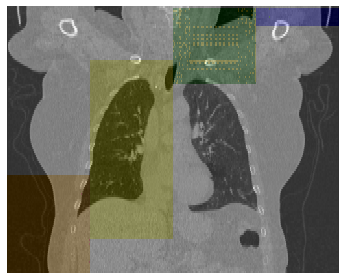

In [ ]:
ct_df_plot = series_df 
regions_df_plot = regions_series_df_keep 

# max number of regions is 6 
colors = ['y', 'r', 'g', 'b', 'c', 'm']
template_region_list = ["Legs", "Pelvis", "Abdomen", "Chest", "Neck", "Head"]

from matplotlib import colors
cmap = colors.ListedColormap(['white','red', 'orange', 'yellow', 'green', 'blue', 'purple'])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')

# For each unique region, annotate the axial extent
unique_regions = list(dict.fromkeys(region_list))
num_unique_regions = len(unique_regions)
print('unique_regions: ' + str(unique_regions))
print('num_unique_regions: ' + str(num_unique_regions))

bpr_slice = np.zeros((img.shape[0],img.shape[2]))
num_slices = img.shape[2]

for n in range(0,num_unique_regions):
  # get the region name 
  region_name = unique_regions[n]
  match_index = template_region_list.index(region_name)
  # get the list of measurement groups for the region 
  measurement_groups = regions_df_plot[regions_df_plot["region"]==unique_regions[n]]["measurementGroup_number"].values
  # get the min value 
  min_index = np.min(measurement_groups)
  # get the max value 
  max_index = np.max(measurement_groups)
  # get the ratios
  min_ratio = np.uint32(np.floor( (n)*(1/num_unique_regions) * dim[0]))
  max_ratio = np.uint32(np.floor( (n+1)*(1/num_unique_regions) * dim[0]))
  # form the slice
  bpr_slice[min_ratio:max_ratio,min_index:max_index] = match_index # so each region will have the same color 


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
bpr_slice_rotated = ndimage.rotate(bpr_slice,90)
ax.imshow(bpr_slice_rotated, cmap=cmap, aspect="auto", alpha=0.2, norm=norm, interpolation='none')
ax.set_aspect(cor_aspect)

plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 


In [ ]:
dim[2]-np.floor((max_index-min_index)/2)

130.0

In [ ]:
# Get corresponding index of this landmark in the total list so we know what color to assign 
landmark_name = landmarks_df_plot['landmark_names'].values[n] 
ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
color_index.append(ind)
slice_index = landmarks_df_plot['slice_index'].values[n]
slice_index = dim[2]-slice_index

# plt.annotate(landmark_name,(dim[0],slice_index)) 
plt.plot([dim[0]-10, dim[0]+10], 
      [slice_index, slice_index],
      color='w', 
      linestyle='-')
plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)

### Query for patients that have the chest as a region 

In [ ]:
# For each series, check if the chest is present in each 

all_series_ids = list(set(regions_series_df['crpes_ref'].values))
num_series_ids = len(all_series_ids) 

# form a df with the region 
region_list = [f['CodeMeaning'] for f in regions_series_df['findingSite'].values]
regions_series_df['region'] = region_list 

series_ids_no_chest = [] 

for n in range(0,num_series_ids): 
  # check if the chest is present 
  series_id = all_series_ids[n]
  region_names = regions_series_df[regions_series_df['crpes_ref']==series_id]['region'].values 
  if ("Chest" not in region_names):
    series_ids_no_chest.append(series_id)
print('series_ids_no_chest: ' + str(series_ids_no_chest)) # maybe can provide ohif links to these. 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


series_ids_no_chest: []


In [ ]:
regions_series_df

,SOPInstanceUID,SeriesInstanceUID,measurementGroup_number,trackingUniqueIdentifier,trackingIdentifier,PatientID,collection_id,sourceSegmentedSeriesUID,sourceReferencedSOPInstanceUID,segmentationInstanceUID,segmentationSegmentNumber,Quantity,Value,finding,findingSite,findingSite_topographicalModifier,crpes_ref,region
0,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,0,1.2.826.0.1.3680043.8.498.75308278544447920705...,Annotations group 1,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2497769927580864205915...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
1,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,1,1.2.826.0.1.3680043.8.498.11239814387089793479...,Annotations group 2,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1617826073701486108266...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
2,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,2,1.2.826.0.1.3680043.8.498.97249681843629269676...,Annotations group 3,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.1859585685983277355842...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
3,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,3,1.2.826.0.1.3680043.8.498.64863452287163244619...,Annotations group 4,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2093065073745037269927...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
4,1.2.826.0.1.3680043.8.498.66040837462453413870...,1.2.826.0.1.3680043.8.498.78872265711982014841...,4,1.2.826.0.1.3680043.8.498.35604830957585200225...,Annotations group 5,LUNG1-206,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.9017839861292378947025...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '113345001', 'CodingSchemeDesign...",None,"{'CodeValue': '113345001', 'CodingSchemeDesign...",None,1.3.6.1.4.1.32722.99.99.6753366146575328532708...,Abdomen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424904,1.2.826.0.1.3680043.8.498.84268390718184772203...,1.2.826.0.1.3680043.8.498.99140887571461489100...,129,1.2.826.0.1.3680043.8.498.25823364206993061087...,Annotations group 130,LUNG1-344,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.2928517606171016583897...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,"{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.1495570040589738841931...,Neck
424905,1.2.826.0.1.3680043.8.498.84268390718184772203...,1.2.826.0.1.3680043.8.498.99140887571461489100...,130,1.2.826.0.1.3680043.8.498.23214833803365614775...,Annotations group 131,LUNG1-344,nsclc_radiomics,None,1.3.6.1.4.1.32722.99.99.3039638450620902366623...,None,[],"{'CodeValue': '363698007', 'CodingSchemeDesign...","{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,"{'CodeValue': '45048000', 'CodingSchemeDesigna...",None,1.3.6.1.4.1.32722.99.99.1495570040589738841931...,Neck
424906,1.2.826.0.1.3680043.8.498.84268390718184772203...,1.2.826.0.1.3680043.8.498.99140887571461489100...,131,1.2.826.0.1.3680043.8.498.12959367487746658582...,Annotations group 132,LU

Now let's compare the percentages that the chest covers over all series

In [ ]:
chest_percentages = [] 

for n in range(0,num_series_ids): 
  series_id = all_series_ids[n] 
  series_df = regions_series_df[regions_series_df['crpes_ref']==series_id]
  # get number of sop instance uids 
  num_sop = len(set(series_df['sourceReferencedSOPInstanceUID'].values))
  # get number where chest is present 
  num_chest = len(series_df[series_df['region'] == 'Chest'])
  chest_percentages.append(num_chest/num_sop)
print(chest_percentages)


[0.5895522388059702, 0.48295454545454547, 0.7798165137614679, 0.8210526315789474, 0.6896551724137931, 0.4027777777777778, 0.9578947368421052, 0.7238805970149254, 0.8829787234042553, 0.7592592592592593, 0.7115384615384616, 0.5671641791044776, 0.8404255319148937, 0.8518518518518519, 0.8817204301075269, 0.7477477477477478, 0.48295454545454547, 0.8157894736842105, 0.6307692307692307, 0.8709677419354839, 0.6779661016949152, 0.6044776119402985, 0.8829787234042553, 0.6434782608695652, 0.6230769230769231, 0.6343283582089553, 0.6074074074074074, 0.6818181818181818, 0.851063829787234, 0.648854961832061, 0.6590909090909091, 0.48863636363636365, 0.6119402985074627, 0.48295454545454547, 0.7131782945736435, 0.8933333333333333, 0.5925925925925926, 0.851063829787234, 0.7457627118644068, 0.6343283582089553, 0.6929824561403509, 0.8736842105263158, 0.794392523364486, 0.8035714285714286, 0.7014925373134329, 0.7454545454545455, 0.5746268656716418, 0.8617021276595744, 0.7456140350877193, 0.7672413793103449,

Let's create a dataframe, link OHIF, and create a boxplot. For this we need the studyInstanceUID for each seriesInstanceUID. So we query. 

In [ ]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      # DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID, 
      StudyInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@all_series_ids);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("all_series_ids", "STRING", all_series_ids)
                                                       ])
series_with_viewer_df = client.query(query, job_config=job_config).to_dataframe()
series_with_viewer_df

bigquery-public-data.idc_current.dicom_all


,viewer_url,SeriesInstanceUID,StudyInstanceUID
0,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.1667573343929554229741...,1.3.6.1.4.1.32722.99.99.7027014250637588263932...
1,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.4095830689707277605367...,1.3.6.1.4.1.32722.99.99.9399693523012870795297...
2,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.3095199853908709261626...,1.3.6.1.4.1.32722.99.99.2349213085953967173488...
3,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.1630402684856032047320...,1.3.6.1.4.1.32722.99.99.5750216525350908585451...
4,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.2066668200544782849861...,1.3.6.1.4.1.32722.99.99.4950223536888418291171...
...,...,...,...
409,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.2025433235220583609629...,1.3.6.1.4.1.32722.99.99.7137892859212679186344...
410,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.2125436972459385371964...,1.3.6.1.4.1.32722.99.99.1603625761689729201350...
411,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.2025068415051316406338...,1.3.6.1.4.1.32722.99.99.2796031606329333843174...
412,https://viewer.imaging.datacommons.cancer.gov/...,1.3.6.1.4.1.32722.99.99.2525550331553145861850...,1.3.6.1.4.1.32722.99.99.4166773060752372709732...


In [ ]:
chest_df = pd.DataFrame() 
chest_df['regions'] = ['Chest'] * len(all_series_ids)
chest_df['SeriesInstanceUID'] = all_series_ids
chest_df['StudyInstanceUID'] = series_with_viewer_df['StudyInstanceUID'].values
chest_df['ratios'] = chest_percentages
chest_df['viewer_url'] = series_with_viewer_df['viewer_url'].values
chest_df

,regions,SeriesInstanceUID,StudyInstanceUID,ratios,viewer_url
0,Chest,1.3.6.1.4.1.32722.99.99.2867144543697108092383...,1.3.6.1.4.1.32722.99.99.7027014250637588263932...,0.589552,https://viewer.imaging.datacommons.cancer.gov/...
1,Chest,1.3.6.1.4.1.32722.99.99.3297323330188683103322...,1.3.6.1.4.1.32722.99.99.9399693523012870795297...,0.482955,https://viewer.imaging.datacommons.cancer.gov/...
2,Chest,1.3.6.1.4.1.32722.99.99.3182383257145620559453...,1.3.6.1.4.1.32722.99.99.2349213085953967173488...,0.779817,https://viewer.imaging.datacommons.cancer.gov/...
3,Chest,1.3.6.1.4.1.32722.99.99.1249933363754750305121...,1.3.6.1.4.1.32722.99.99.5750216525350908585451...,0.821053,https://viewer.imaging.datacommons.cancer.gov/...
4,Chest,1.3.6.1.4.1.32722.99.99.7913551369089975672566...,1.3.6.1.4.1.32722.99.99.4950223536888418291171...,0.689655,https://viewer.imaging.datacommons.cancer.gov/...
...,...,...,...,...,...
409,Chest,1.3.6.1.4.1.32722.99.99.5923240217949809696811...,1.3.6.1.4.1.32722.99.99.7137892859212679186344...,0.669291,https://viewer.imaging.datacommons.cancer.gov/...
410,Chest,1.3.6.1.4.1.32722.99.99.1972216421123761393033...,1.3.6.1.4.1.32722.99.99.1603625761689729201350...,0.904255,https://viewer.imaging.datacommons.cancer.gov/...
411,Chest,1.3.6.1.4.1.32722.99.99.1386291722721855937686...,1.3.6.1.4.1.32722.99.99.2796031606329333843174...,0.682927,https://viewer.imaging.datacommons.cancer.gov/...
412,Chest,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,1.3.6.1.4.1.32722.99.99.4166773060752372709732...,0.757009,https://viewer.imaging.datacommons.cancer.gov/...


In [ ]:
df_plot = chest_df

Now plot a boxplot showing the distribution of percentages 

In [ ]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row


In [ ]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

In [ ]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

df_plot 

# Get a list of unique colors that match the order of the regions
# num_colors = len(list(set(colors)))
# colors = [] 
# for n in range(0,num_colors):
#   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   colors.append(c)

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Ratio)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           # x_range=cats, 
           title="Ratios of slices assigned to each region")

p.circle(y='ratios', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot['regions'] = df_plot['regions'].astype(category_region)

groups = df_plot.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.ratios,
    top=q3.ratios,
    fill_color=colors,
    legend=cats
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.ratios,
    top=q2.ratios,
    fill_color=colors
))
 
 
# p = figure(tools="save", title="", x_range=df_plot.regions.unique())
 
# stems (Don't need colors of treatment)
p.segment(cats, upper.ratios, cats, q3.ratios, line_color="black")
p.segment(cats, lower.ratios, cats, q1.ratios, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.ratios, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.ratios, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
 
p.add_layout(legend, 'below')    
 
# Setup plot titles and such.
p.title.text = "Ratio of slices for each body part examined region"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Ratio"
p.legend.location = (100,10)
 
# show(p)



########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)


#### 


check this value: 1
('#1b9e77',)
colormap: {'Chest': '#1b9e77'}
colormap_list_keys: ['Chest']
regions: ['Chest']
colors: ['#1b9e77']
cats: ['Chest']
regions: ['Chest']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Download the regions DICOM SR for a single series 

In [ ]:
# landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_regions = regions_series_df['SOPInstanceUID'].values
SOPInstanceUID_region = SOPInstanceUID_regions[0] 
SOPInstanceUID_region 

'1.2.826.0.1.3680043.8.498.21061870466070764068508062138024860842'

In [ ]:
# Instead try with this SOPInstanceUID from LUNG1-001 as we know the first slice has 2 landmarks 

# SOPInstanceUID_landmark = '1.2.826.0.1.3680043.8.498.98304286221164847735172539704744156702'


In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_region)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

,SeriesDescription,gcs_url
0,BPR region annotations,gs://public-datasets-idc/ab50a4ce-1c66-4922-b0...


In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_regions"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/ab50a4ce-1c66-4922-b0b8-25f169187bb6.dcm...
/ [1/1 files][152.4 KiB/152.4 KiB] 100% Done                                    
Operation completed over 1 objects/152.4 KiB.                                    
/content/sr_regions/ab50a4ce-1c66-4922-b0b8-25f169187bb6.dcm
/content/sr_regions/sr.dcm


'/content/sr_regions/sr.dcm'

### Use highdicom to read extract the relevant fields from the SR

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

regions_sr_df = pd.DataFrame() 
slice_indices = [] 
region_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain regions 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_regions = len(containers_level2)
# print('num_slices_with_regions: ' + str(num_slices_with_regions))

# Loop over num_slices_with_regions
for slice_index in range(0,num_slices_with_regions):

  # print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
    dataset=containers_level2[slice_index],
    relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the region
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_regions_in_slice = len(containers_level3)
  # print('   num_regions_in_slice: ' + str(num_regions_in_slice))

  # Loop over the number of regions in the slice 
  for region_index in range(0,num_regions_in_slice): 

    # Now get the region name 
    region_name = hd.sr.utils.get_coded_value(containers_level3[region_index])['CodeMeaning'].value
    # print('   region_name: ' + str(region_name))

    slice_indices.append(slice_index)
    region_names.append(region_name)
    ref_sop_ids.append(sop_instance_uid)



# Create df
regions_sr_df['slice_index'] = slice_indices
regions_sr_df['region_name'] = region_names 
regions_sr_df['ref_sop_id'] = ref_sop_ids

regions_sr_df

sr_file: /content/sr_regions/sr.dcm


,slice_index,region_name,ref_sop_id
0,0,Abdomen,1.3.6.1.4.1.32722.99.99.1725268650834763767057...
1,1,Abdomen,1.3.6.1.4.1.32722.99.99.1293645693754237467902...
2,2,Abdomen,1.3.6.1.4.1.32722.99.99.1202989843503726553501...
3,3,Abdomen,1.3.6.1.4.1.32722.99.99.1065485646772339129535...
4,4,Abdomen,1.3.6.1.4.1.32722.99.99.9790104117165574828585...
...,...,...,...
194,130,Head,1.3.6.1.4.1.32722.99.99.5211685887577845628123...
195,131,Head,1.3.6.1.4.1.32722.99.99.1097725445974189382713...
196,132,Head,1.3.6.1.4.1.32722.99.99.2382707982603339029007...
197,133,Head,1.3.6.1.4.1.32722.99.99.2177563741043547935980...


In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

landmarks_sr_df = pd.DataFrame() 
slice_indices = [] 
landmark_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain landmarks 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_landmarks = len(containers_level2)
print('num_slices_with_landmarks: ' + str(num_slices_with_landmarks))

# Loop over num_slices_with_landmarks
for slice_index in range(0,num_slices_with_landmarks):

  print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
  dataset=containers_level2[slice_index],
  relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the landmark and modifier 
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_landmarks_in_slice = len(containers_level3)
  print('   num_landmarks_in_slice: ' + str(num_landmarks_in_slice))

  # Loop over the number of landmarks in the slice 
  for landmark_index in range(0,num_landmarks_in_slice): 

    # Now get the landmark name 
    landmark_name = hd.sr.utils.get_coded_value(containers_level3[landmark_index])['CodeMeaning'].value
    print('   landmark_name: ' + str(landmark_name))

    # Now get the modifier
    modifier =  hd.sr.utils.find_content_items(
        dataset=containers_level3[landmark_index],
        relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
        value_type=ValueTypeValues.CODE
    )
    modifier_name = hd.sr.utils.get_coded_value(modifier[0])['CodeMeaning'].value
    print('   modifier_name: ' + str(modifier_name))

    slice_indices.append(slice_index)
    landmark_names.append(landmark_name)
    modifier_names.append(modifier_name)
    ref_sop_ids.append(sop_instance_uid)

# Create df
landmarks_sr_df['landmark_name'] = landmark_names 
landmarks_sr_df['modifier_name'] = modifier_names 
landmarks_sr_df['ref_sop_id'] = ref_sop_ids

landmarks_sr_df



sr_file: /content/sr_landmarks/sr.dcm
num_slices_with_landmarks: 20
slice_index: 0
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.305629633035562593745800399744408635913
   num_landmarks_in_slice: 2
   landmark_name: Kidney
   modifier_name: Bottom
   landmark_name: L2 vertebra
   modifier_name: Center
slice_index: 1
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.43054485334186588574623352561885187921
   num_landmarks_in_slice: 1
   landmark_name: L1 vertebra
   modifier_name: Center
slice_index: 2
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.263159010186857259023681147179880990863
   num_landmarks_in_slice: 1
   landmark_name: Lung
   modifier_name: Bottom
slice_index: 3
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.82802603186227822638651463200656463022
   num_landmarks_in_slice: 1
   landmark_name: T12 vertebra
   modifier_name: Center
slice_index: 4
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.8901906612198818796071007089102165819
 

,landmark_name,modifier_name,ref_sop_id
0,Kidney,Bottom,1.3.6.1.4.1.32722.99.99.3056296330355625937458...
1,L2 vertebra,Center,1.3.6.1.4.1.32722.99.99.3056296330355625937458...
2,L1 vertebra,Center,1.3.6.1.4.1.32722.99.99.4305448533418658857462...
3,Lung,Bottom,1.3.6.1.4.1.32722.99.99.2631590101868572590236...
4,T12 vertebra,Center,1.3.6.1.4.1.32722.99.99.8280260318622782263865...
5,T11 vertebra,Center,1.3.6.1.4.1.32722.99.99.8901906612198818796071...
6,T10 vertebra,Center,1.3.6.1.4.1.32722.99.99.1651333239617429298390...
7,T9 vertebra,Center,1.3.6.1.4.1.32722.99.99.9243908860590178711883...
8,Liver,Top,1.3.6.1.4.1.32722.99.99.1378828584856047266870...
9,T8 vertebra,Center,1.3.6.1.4.1.32722.99.99.2451475860807041443665...


### Use dcmqi to read the SR 